In [329]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [433]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures):
    ratings = {}
    league_ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int_results['HomeDiv'])).union(set(df_int_fixtures['HomeDiv'])).union(set(df_int_results['AwayDiv'])).union(set(df_int_fixtures['AwayDiv']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam'])).union(set(df_int_results['HomeTeam'])).union(set(df_int_fixtures['HomeTeam'])).union(set(df_int_results['AwayTeam'])).union(set(df_int_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
            
    """
    # Initialize ratings for each competition
    league_ratings['REST'] = {
        'brH': 0.0,
        'brA': 0.0,
        'continuous_overunderperformances': 0
    }
    """
    
    for competition in competitions:
        if '1' in competition:  # Check if it's a top tier league
            league_ratings[competition] = {
                'INT1': {
                    'brH': 0.0,
                    'brA': 0.0,
                    'continuous_overunderperformances': 0,
                },
                'DCUP': {
                    'brH': 0.5,
                    'brA': 0.5 * 0.96,
                    'continuous_overunderperformances': 0,
                }
            }
        else:  # Assume it's a second tier league otherwise
            league_ratings[competition] = {
                'INT1': {
                    'brH': 0.0,
                    'brA': 0.0,
                    'continuous_overunderperformances': 0,
                },
                'DCUP': {
                    'brH': -0.5,
                    'brA': -0.5 * 0.96,
                    'continuous_overunderperformances': 0,
                }
            }
            
    #print('Teams:', teams, end='\n\n')
    return ratings, league_ratings


In [434]:
def initialize_rest_ratings(rest_teams):
    rest_ratings = {}
    for team in rest_teams:
        rest_ratings[team] = {
            'REST': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
        }
    return rest_ratings

In [435]:
def create_team_to_league_mapping(df_results, df_fixtures, df_int):
    team_to_league = {}
    rest_teams = set() # To store teams that are assigned to the 'REST' league

    def get_league_level(division):
        # Extracting the integer part from the division
        integer_part = ''.join(filter(str.isdigit, division))
        return int(integer_part)


    # Iterate through the results and fixtures dataframes and map teams to their leagues
    for df in [df_results, df_fixtures]:
        for index, row in df.iterrows():
            for team in [row['HomeTeam'], row['AwayTeam']]:
                current_div = row['Div']
                current_level = get_league_level(current_div)

                # If the team is not yet in the dictionary, or if the current league is higher, update the entry
                if team not in team_to_league or current_level < get_league_level(team_to_league[team]):
                    team_to_league[team] = current_div

    # Now process df_int
    for index, row in df_int.iterrows():
        for team in [row['HomeTeam'], row['AwayTeam']]:
            if team not in team_to_league:
                # If the team is not found in the other dataframes, assign it to 'REST'
                team_to_league[team] = 'REST'
                rest_teams.add(team)

    return team_to_league, rest_teams

In [436]:
def get_league_from_team(team, team_to_league):
    return team_to_league.get(team, 'REST')

In [437]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, league_ratings, rates):
    ind_threshold = rates['ind_threshold']
    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > ind_threshold:
            #add current game to training data
            training_games.append({
                #"brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                #"brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                #"prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0],
                #"prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[1],
                #"brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                #"brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                #"prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[0],
                #"prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1],
                #"rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1]),
                "rating_difference": ratings[row["HomeTeam"]][competition]["brH"] - ratings[row["AwayTeam"]][competition]["brA"],
                #"FTHG": row["FTHG"],
                #"FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })

        """
        if np.isnan(ratings[row["HomeTeam"]][competition]["brH"]):
            print("error")
            break
        """
        
        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        
        """
        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })
        """

    return ratings, games_with_rating, training_games

In [438]:
def update_league_ratings_multiple_games(df_int_results, league_ratings, rates):
    # Iterate over each match in the international results data
    for index, row in df_int_results.iterrows():
        # Extract relevant information from the row
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']
        Div = row['Div']
        FTHG = row['FTHG']
        FTAG = row['FTAG']

        # Update the league ratings based on the match result
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates)

    return league_ratings


In [468]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, league_ratings, rates, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma']
    

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)

    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)
    
    competitions = set(ratings[HomeTeam].keys()).union(set(ratings[AwayTeam].keys()))
    
    tau = rates['tau']
    
    
    for team in [HomeTeam, AwayTeam]:
        if ratings[team][competition]['brH'] == 0 and ratings[team][competition]['brA'] == 0 and league_ratings[competition]['DCUP']['brH'] != 0:
            for otherCompetition in competitions:
                if ratings[team][otherCompetition]['brH'] != 0 or ratings[team][otherCompetition]['brA'] != 0:
                    if '2' in otherCompetition and '1' in competition:  # promotion
                        promoted_teams_ratings[team] = ((ratings[team][otherCompetition]['brH'] + ratings[team][otherCompetition]['brA']) / 2)            
                    elif '1' in otherCompetition and '2' in competition:  # relegation
                        relegated_teams_ratings[team] = ((ratings[team][otherCompetition]['brH'] + ratings[team][otherCompetition]['brA']) / 2)
                    else:
                        print("error at init")
                    #print(league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                    ratings[team][competition]['brH'] = ratings[team][otherCompetition]['brH'] + tau *(league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                    ratings[team][competition]['brA'] = ratings[team][otherCompetition]['brA'] + tau *(league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA'])
                    break
             
    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)
    
        

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])
    """
    if HomeTeam == 'Liverpool' and AwayTeam == 'Man United' and FTHG == 7:
        print('Observed Goal Difference:', observed_goal_difference)
        print('Expected Goals x:', expected_goal_x)
        print('Expected Goals y:', expected_goal_y)
        print('Expected Goal Difference:', expected_goal_difference)
        print('Error:', error)
        print('Psi:', psi_temp)
        print('Diminishing Function psi x:', diminishing_function_psi_x)
        print('Diminishing Function psi y:', diminishing_function_psi_y)
        print('Old brH x:', previous_home_rating_x)
        print('Old brA x:', previous_away_rating_x)
        print('Old brH y:', previous_home_rating_y)
        print('Old brA y:', previous_away_rating_y)
        print('New brH x:', ratings[HomeTeam][competition]['brH'])
        print('New brA x:', ratings[HomeTeam][competition]['brA'])
        print('New brH y:', ratings[AwayTeam][competition]['brH'])
        print('New brA y:', ratings[AwayTeam][competition]['brA'])
    """
    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [469]:
# Function to update ratings based on results data
def update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda2']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma2']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(league_ratings[HomeLeague][Div]['brH']) / 3
    expected_goal_x = np.sign(league_ratings[HomeLeague][Div]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(league_ratings[AwayLeague][Div]['brA']) / 3
    expected_goal_y = np.sign(league_ratings[AwayLeague][Div]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = league_ratings[HomeLeague][Div]['brH']
    previous_away_rating_x = league_ratings[HomeLeague][Div]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    league_ratings[HomeLeague][Div]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    league_ratings[HomeLeague][Div]['brA'] = previous_away_rating_x + (league_ratings[HomeLeague][Div]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = league_ratings[AwayLeague][Div]['brH']
    previous_away_rating_y = league_ratings[AwayLeague][Div]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    league_ratings[AwayLeague][Div]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    league_ratings[AwayLeague][Div]['brH'] = previous_home_rating_y + (league_ratings[AwayLeague][Div]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] + 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] - 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] + 1)
    else:
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = 0
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return league_ratings


In [470]:
def calculate_provisional_ratings(ratings, team, competition, rates):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    #form_threshold_phi = 1
    form_threshold_phi = rates['phi']

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    #rating_impact_mu = 0.01
    rating_impact_mu = rates['mu']

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    #diminishing_factor_delta = 2.5
    diminishing_factor_delta = rates['delta']

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away

    return brH, brA
    
    
    phi_current = abs(ratings[team][competition]['continuous_overunderperformances'])
    
    if abs(phi_current) < (form_threshold_phi + 1):
        return brH, brA
    
    """
    prH = brH
    prA = brA
    
    phi_diff = int(abs(phi_current) - form_threshold_phi)
    #print("phi_diff:", phi_diff)
    for i in range(phi_diff):
        # Calculate performance factor for home team x
        a = phi_diff - i
        b = a ** diminishing_factor_delta
        form_factor_home = a / b
        
        prH += np.sign(phi_current) * rating_impact_mu * form_factor_home
        prA += np.sign(phi_current) * rating_impact_mu * form_factor_home
    """
    
    # Calculate performance factor for home team x
    a = abs(phi_current) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (phi_current > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    elif (phi_current < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home
    else:
        prH = brH
        prA = brA
    
        
    return prH, prA

In [471]:
def calculate_probabilities(features, model):

    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [472]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, Awayleague, rates):
    rho = rates['rho']
    sigma = rates['sigma']
    
    competition1 = competition
    competition2 = competition
    if competition == 'INT1':
        competition1 = HomeLeague
        competition2 = Awayleague
        
    # Calculate provisional ratings if necessary
    home_rating_x = ratings[HomeTeam][competition1]['brH']
    away_rating_y = ratings[AwayTeam][competition2]['brA']
    if (abs(ratings[HomeTeam][competition1]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition1, rates)
        home_rating_x = provisional_ratings_x[0]
    if (abs(ratings[AwayTeam][competition2]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition2, rates)
        away_rating_y = provisional_ratings_y[1]
    
    if competition == 'INT1':
        """
        if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Prior home rating x:', home_rating_x)
            print('Prior away rating y:', away_rating_y)
            print('Home league rating x:', league_ratings[competition1]['INT1']['brH'])
            print('Away league rating y:', league_ratings[competition2]['INT1']['brA'])
        """
        home_rating_x = rho * home_rating_x + sigma * league_ratings[competition1]['INT1']['brH']
        away_rating_y = rho * away_rating_y + sigma * league_ratings[competition2]['INT1']['brA']

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y
    """
    if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Int home rating x:', home_rating_x)
            print('Int away rating y:', away_rating_y)
            print('Rating difference:', rating_difference, end='\n\n')
    """
    return rating_difference

In [473]:
def predict_outcomes(df_fixtures, ratings, league_ratings, rates, model):
    
    all_rps = []
    league_ratings_fake = {}
    HomeLeague = 'fake'
    Awayleague = 'fake'

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']
        
        """
        if index == 4039:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Prior home rating x: ', ratings[HomeTeam][competition]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][competition]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][competition]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][competition]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
        """
        """
        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings_fake, HomeLeague, Awayleague, rates)
        

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)
        


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)
        

        # Update league table
       #league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)
        
        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        """
        if index == 4039:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        """
    #print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')
    
    """
    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table
    """
    
    return all_rps, league_tables


In [474]:
def predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model):

    int_rps = []
    
    for index, row in df_int_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']

        competition = row['Div']
        """
        if index == 124:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Home League: ', HomeLeague)
            print('Away League: ', AwayLeague)
            print('Prior home rating x: ', ratings[HomeTeam][HomeLeague]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][HomeLeague]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][AwayLeague]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][AwayLeague]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
            print('Prior home league rating x: ', league_ratings[HomeLeague]['INT1']['brH'])
            print('Prior away league rating x: ', league_ratings[HomeLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of x: ', league_ratings[HomeLeague]['INT1']['continuous_overunderperformances'])
            print('Prior home league rating y: ', league_ratings[AwayLeague]['INT1']['brH'])
            print('Prior away league rating y: ', league_ratings[AwayLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of y: ', league_ratings[AwayLeague]['INT1']['continuous_overunderperformances'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, AwayLeague, rates)
        
            
            

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n')
        """
        

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        int_rps.append(rps_score)
        
        """
        if index == 124:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        
        """

        # Update league_ratings
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, competition, row['FTHG'], row['FTAG'], league_ratings, rates)

    print(f"RPS for {competition}:", np.mean(int_rps), '\n')


    return int_rps

In [475]:
def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [476]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [477]:

from sklearn.ensemble import GradientBoostingClassifier


def train_model(df_train):

    # Create Logistic Regression model
    #model = GradientBoostingClassifier(n_estimators=100)
    model = LogisticRegression(solver="saga", penalty="l2")  
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000, random_state=23)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    #score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model

;

''

In [479]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('../data/new_season_2016-2022_sorted_compressed_top2.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('../data/new_season_2022-2023_sorted_top2.csv')

# Load the international results data file
df_int_results = pd.read_csv('../data/new_season_2016-2022_INT.csv')

# Load the international fixtures data file
df_int_fixtures = pd.read_csv('../data/new_season_2022-2023_INT.csv')

# Load the domestic cup results data file
df_dcup_results = pd.read_csv('../data/cleaned_new_season_2016-2022_DCUP.csv')

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.86,
    'sigma': 0.7,
    'tau': 1.3,
    'ind_threshold': 6000,
    'lambda2': 0.13,
    'gamma2': 0.96,
}

# Map teams to leagues
df_int = pd.concat([df_int_results, df_int_fixtures], ignore_index=True)
#team_to_league, rest_teams = create_team_to_league_mapping(df_results, df_fixtures, df_int)

# Initialize ratings based on the results data
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)



promoted_teams_ratings = {}
relegated_teams_ratings = {}

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
#model.C_

# Train the model for predicting match outcomes
df_train = pd.DataFrame(training_games)
df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)



"""
# Create a reverse mapping of leagues to teams
league_to_teams = {}
for team, league in team_to_league.items():
    if league not in league_to_teams:
        league_to_teams[league] = []
    league_to_teams[league].append(team)

# Print the teams sorted by league
for league, teams in sorted(league_to_teams.items()):
    print(f"{league}:")
    print(", ".join(teams))
    print()
"""

# Update league ratings based on the results data here
league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
league_ratings = update_league_ratings_multiple_games(df_dcup_results, league_ratings, rates)

for league, values in league_ratings.items():
    if values['INT1']['brH'] == 0:
        continue
    # International rating
    #print(f"League: {league} (International), Rating: {(values['INT1']['brH'] + values['INT1']['brA']) / 2}")
    
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    # National rating
    #print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")


# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
    all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)

"""
print("Promoted teams and their average ratings:")
for team, rating in promoted_teams_ratings.items():
    print(f"{team}: {rating}")

print("\nRelegated teams and their average ratings:")
for team, rating in relegated_teams_ratings.items():
    print(f"{team}: {rating}")

print('Average Rating of promoted teams:', np.mean(list(promoted_teams_ratings.values())))
print('Average Rating of relegated teams:', np.mean(list(relegated_teams_ratings.values())))
"""

int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)

"""
# print the ratings of each league in DCUP
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")
"""

#combine int_rps and all_rps to one list
combine_rps = all_rps + int_rps

mean_combine_rps = np.mean(combine_rps)
print('Final average RPS Score:', mean_combine_rps)
;

Average RPS Score across all competitions: 0.2055723312304625
RPS for INT1: 0.18939335428290593 

Final average RPS Score: 0.20523174986999695


''

In [466]:
# Gridsearch on taus

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.86,
    'sigma': 0.7,
    'tau': 1.3,
    'lambda2': 0.13,
    'gamma2': 0.96,
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'tau_promotion': np.linspace(1.2, 1.6, 5),
    'tau_relegation': np.linspace(1.2, 1.6, 5)
}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results_tau = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)
    
    all_rps = []
    
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(all_rps)

    score = mean_rps
    

    # Store the current results
    gs_results_tau.append({
        'tau_promotion': rates['tau_promotion'],
        'tau_relegation': rates['tau_relegation'],
        'score': score,
    })
    
    print(f"Tau Promotion: {rates['tau_promotion']}, Tau Relegation: {rates['tau_relegation']}, Score: {score}")

  4%|▍         | 1/25 [00:08<03:17,  8.23s/it]

Tau Promotion: 1.2, Tau Relegation: 1.2, Score: 0.2055144758231203


  8%|▊         | 2/25 [00:12<02:14,  5.83s/it]

Tau Promotion: 1.2, Tau Relegation: 1.3, Score: 0.20551376634241833


 12%|█▏        | 3/25 [00:16<01:51,  5.05s/it]

Tau Promotion: 1.2, Tau Relegation: 1.4, Score: 0.20552256174235092


 16%|█▌        | 4/25 [00:20<01:38,  4.68s/it]

Tau Promotion: 1.2, Tau Relegation: 1.5, Score: 0.2055421852142057


 20%|██        | 5/25 [00:24<01:29,  4.48s/it]

Tau Promotion: 1.2, Tau Relegation: 1.6, Score: 0.20557068797698808


 24%|██▍       | 6/25 [00:28<01:23,  4.40s/it]

Tau Promotion: 1.3, Tau Relegation: 1.2, Score: 0.20551580024450403


 28%|██▊       | 7/25 [00:33<01:19,  4.42s/it]

Tau Promotion: 1.3, Tau Relegation: 1.3, Score: 0.2055098301069225


 32%|███▏      | 8/25 [00:37<01:13,  4.32s/it]

Tau Promotion: 1.3, Tau Relegation: 1.4, Score: 0.2055149758334397


 36%|███▌      | 9/25 [00:41<01:08,  4.27s/it]

Tau Promotion: 1.3, Tau Relegation: 1.5, Score: 0.205530666829669


 40%|████      | 10/25 [00:45<01:03,  4.20s/it]

Tau Promotion: 1.3, Tau Relegation: 1.6, Score: 0.20555488800062718


 44%|████▍     | 11/25 [00:49<00:58,  4.15s/it]

Tau Promotion: 1.4, Tau Relegation: 1.2, Score: 0.20552215139298638


 48%|████▊     | 12/25 [00:53<00:53,  4.13s/it]

Tau Promotion: 1.4, Tau Relegation: 1.3, Score: 0.2055117375942838


 52%|█████▏    | 13/25 [00:58<00:49,  4.15s/it]

Tau Promotion: 1.4, Tau Relegation: 1.4, Score: 0.20551243347072104


 56%|█████▌    | 14/25 [01:02<00:46,  4.25s/it]

Tau Promotion: 1.4, Tau Relegation: 1.5, Score: 0.20552453192797665


 60%|██████    | 15/25 [01:06<00:41,  4.20s/it]

Tau Promotion: 1.4, Tau Relegation: 1.6, Score: 0.20554524598624854


 64%|██████▍   | 16/25 [01:10<00:37,  4.18s/it]

Tau Promotion: 1.5, Tau Relegation: 1.2, Score: 0.20553239807771337


 68%|██████▊   | 17/25 [01:14<00:33,  4.14s/it]

Tau Promotion: 1.5, Tau Relegation: 1.3, Score: 0.20551789872616114


 72%|███████▏  | 18/25 [01:18<00:28,  4.12s/it]

Tau Promotion: 1.5, Tau Relegation: 1.4, Score: 0.20551455397782906


 76%|███████▌  | 19/25 [01:22<00:24,  4.10s/it]

Tau Promotion: 1.5, Tau Relegation: 1.5, Score: 0.20552202932707242


 80%|████████  | 20/25 [01:27<00:20,  4.11s/it]

Tau Promotion: 1.5, Tau Relegation: 1.6, Score: 0.20553987773005708


 84%|████████▍ | 21/25 [01:31<00:16,  4.19s/it]

Tau Promotion: 1.6, Tau Relegation: 1.2, Score: 0.2055474545129792


 88%|████████▊ | 22/25 [01:35<00:12,  4.19s/it]

Tau Promotion: 1.6, Tau Relegation: 1.3, Score: 0.2055283624594303


 92%|█████████▏| 23/25 [01:39<00:08,  4.17s/it]

Tau Promotion: 1.6, Tau Relegation: 1.4, Score: 0.20552095051180733


 96%|█████████▌| 24/25 [01:43<00:04,  4.15s/it]

Tau Promotion: 1.6, Tau Relegation: 1.5, Score: 0.2055250454264121


100%|██████████| 25/25 [01:47<00:00,  4.32s/it]

Tau Promotion: 1.6, Tau Relegation: 1.6, Score: 0.20553929172474344


In [467]:
# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results_tau, key=lambda x: x['score'])[:30]

print("Top 5 combinations:")
for combo in top_combinations:
    print(f"Tau Promotion: {combo['tau_promotion']}, Tau Relegation: {combo['tau_relegation']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results_tau = pd.DataFrame(gs_results_tau)
#to csv
df_gs_results_tau.to_csv("../data/gs_results_tau.csv", index=False)

Top 5 combinations:
Tau Promotion: 1.3, Tau Relegation: 1.3, Score: 0.2055098301069225
Tau Promotion: 1.4, Tau Relegation: 1.3, Score: 0.2055117375942838
Tau Promotion: 1.4, Tau Relegation: 1.4, Score: 0.20551243347072104
Tau Promotion: 1.2, Tau Relegation: 1.3, Score: 0.20551376634241833
Tau Promotion: 1.2, Tau Relegation: 1.2, Score: 0.2055144758231203
Tau Promotion: 1.5, Tau Relegation: 1.4, Score: 0.20551455397782906
Tau Promotion: 1.3, Tau Relegation: 1.4, Score: 0.2055149758334397
Tau Promotion: 1.3, Tau Relegation: 1.2, Score: 0.20551580024450403
Tau Promotion: 1.5, Tau Relegation: 1.3, Score: 0.20551789872616114
Tau Promotion: 1.6, Tau Relegation: 1.4, Score: 0.20552095051180733
Tau Promotion: 1.5, Tau Relegation: 1.5, Score: 0.20552202932707242
Tau Promotion: 1.4, Tau Relegation: 1.2, Score: 0.20552215139298638
Tau Promotion: 1.2, Tau Relegation: 1.4, Score: 0.20552256174235092
Tau Promotion: 1.4, Tau Relegation: 1.5, Score: 0.20552453192797665
Tau Promotion: 1.6, Tau Relegati

In [ ]:
competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int['HomeDiv'])).union(set(df_int['AwayDiv']))
for competition in competitions:
    print(competition,':', ratings['Basel'][competition])

In [ ]:
                 
plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool", "Everton", "Leicester", "West Ham", "Southampton"]
#teams = ['Arsenal', 'Man City', 'Barcelona', 'Real Madrid', 'Bayern Munich', 'Dortmund', 'Paris SG', 'Napoli', 'Juventus']
#teams = league_to_teams['E0']
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time232.png", dpi=300)

;

In [ ]:
# Print league tables
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

In [ ]:
# Plot RPS distribution
plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=25)
plt.savefig("../images/rps_distribution232.png", dpi=300)



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

In [ ]:
# Gridsearch on lambda and gamma

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'tau': 0.001,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda': np.linspace(0.04, 0.05, 11),
    'gamma': np.linspace(0.95, 1.0, 6)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)
    
    all_rps = []
    
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(all_rps)

    score = mean_rps
    

    # Store the current results
    gs_results.append({
        'lambda': rates['lambda'],
        'gamma': rates['gamma'],
        'score': score,
    })
    
    print(f"Lambda: {rates['lambda']}, Gamma: {rates['gamma']}, Score: {score}")



In [ ]:
# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda x: x['score'])[:10]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"Lambda: {combo['lambda']}, Gamma: {combo['gamma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results = pd.DataFrame(gs_results)
#to csv
df_gs_results.to_csv("../data/gs_resultslamgam_precise.csv", index=False)



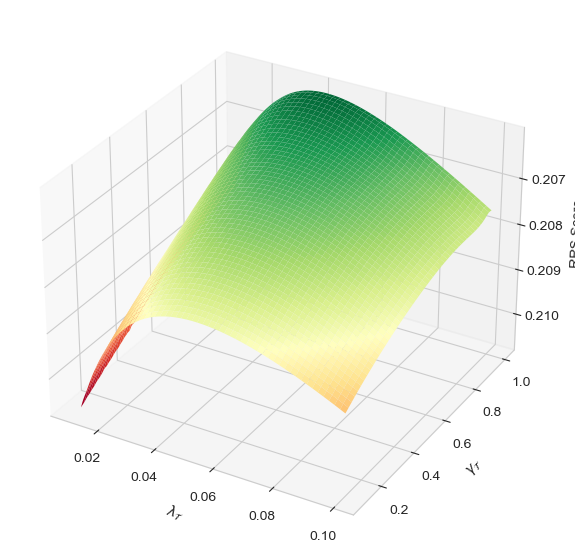

''

In [65]:
df_gs_results = pd.read_csv("../data/gs_resultslamgam_full_range.csv")

# Define grid of x, y values
lambda_range = np.linspace(0.01, 0.1, num=1000)
gamma_range = np.linspace(0.1, 1.0, num=1000)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['lambda'], df_gs_results['gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\lambda_{\mathcal{T}}$')
ax.set_ylabel(r'$\gamma_{\mathcal{T}}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_lg.png", dpi=300)
plt.show()

;

In [49]:
# Gridsearch on lambda2 and gamma2

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.75,
    'sigma': 0.75,
    'tau': 0.001,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda2': np.linspace(0.0, 0.2, 21),
    'gamma2': np.linspace(0.0, 1.0, 21)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results2 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results2.append({
        'lambda2': rates['lambda2'],
        'gamma2': rates['gamma2'],
        'score': score,
    })
    
    print(f"Lambda2: {rates['lambda2']}, Gamma2: {rates['gamma2']}, Score: {score}")



  0%|          | 2/441 [00:00<00:38, 11.43it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.0, Score: 0.2105034717849795
RPS for INT1: 0.20029343749638256 

Lambda2: 0.01, Gamma2: 0.0, Score: 0.20029343749638256
RPS for INT1: 0.19726288732049968 

Lambda2: 0.02, Gamma2: 0.0, Score: 0.19726288732049968


  1%|▏         | 6/441 [00:00<00:38, 11.16it/s]

RPS for INT1: 0.19608399210845434 

Lambda2: 0.03, Gamma2: 0.0, Score: 0.19608399210845434
RPS for INT1: 0.19549400298537095 

Lambda2: 0.04, Gamma2: 0.0, Score: 0.19549400298537095
RPS for INT1: 0.19519125234080334 

Lambda2: 0.05, Gamma2: 0.0, Score: 0.19519125234080334


  2%|▏         | 8/441 [00:00<00:38, 11.14it/s]

RPS for INT1: 0.19507867618007135 

Lambda2: 0.06, Gamma2: 0.0, Score: 0.19507867618007135
RPS for INT1: 0.19508552097202128 

Lambda2: 0.07, Gamma2: 0.0, Score: 0.19508552097202128
RPS for INT1: 0.19515770812316266 

Lambda2: 0.08, Gamma2: 0.0, Score: 0.19515770812316266
RPS for INT1: 0.1952525087726391 

Lambda2: 0.09, Gamma2: 0.0, Score: 0.1952525087726391


  3%|▎         | 12/441 [00:01<00:38, 11.13it/s]

RPS for INT1: 0.19534963802346847 

Lambda2: 0.1, Gamma2: 0.0, Score: 0.19534963802346847
RPS for INT1: 0.1954441217099716 

Lambda2: 0.11, Gamma2: 0.0, Score: 0.1954441217099716
RPS for INT1: 0.19553767373762526 

Lambda2: 0.12, Gamma2: 0.0, Score: 0.19553767373762526


  4%|▎         | 16/441 [00:01<00:37, 11.21it/s]

RPS for INT1: 0.19563484226106126 

Lambda2: 0.13, Gamma2: 0.0, Score: 0.19563484226106126
RPS for INT1: 0.19574029906324758 

Lambda2: 0.14, Gamma2: 0.0, Score: 0.19574029906324758
RPS for INT1: 0.19586277124961912 

Lambda2: 0.15, Gamma2: 0.0, Score: 0.19586277124961912


  4%|▍         | 18/441 [00:01<00:38, 11.13it/s]

RPS for INT1: 0.19599631255388367 

Lambda2: 0.16, Gamma2: 0.0, Score: 0.19599631255388367
RPS for INT1: 0.19613843883073212 

Lambda2: 0.17, Gamma2: 0.0, Score: 0.19613843883073212
RPS for INT1: 0.19629917802112773 

Lambda2: 0.18, Gamma2: 0.0, Score: 0.19629917802112773
RPS for INT1: 0.19648949387798983 

Lambda2: 0.19, Gamma2: 0.0, Score: 0.19648949387798983


  5%|▍         | 22/441 [00:01<00:37, 11.14it/s]

RPS for INT1: 0.19671628112151354 

Lambda2: 0.2, Gamma2: 0.0, Score: 0.19671628112151354
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.05, Score: 0.2105034717849795
RPS for INT1: 0.19995457853127835 

Lambda2: 0.01, Gamma2: 0.05, Score: 0.19995457853127835


  6%|▌         | 26/441 [00:02<00:37, 11.13it/s]

RPS for INT1: 0.196885331251735 

Lambda2: 0.02, Gamma2: 0.05, Score: 0.196885331251735
RPS for INT1: 0.1957266926698985 

Lambda2: 0.03, Gamma2: 0.05, Score: 0.1957266926698985
RPS for INT1: 0.19517411929859363 

Lambda2: 0.04, Gamma2: 0.05, Score: 0.19517411929859363


  6%|▋         | 28/441 [00:02<00:37, 11.08it/s]

RPS for INT1: 0.19490809595785888 

Lambda2: 0.05, Gamma2: 0.05, Score: 0.19490809595785888
RPS for INT1: 0.19482260564526416 

Lambda2: 0.06, Gamma2: 0.05, Score: 0.19482260564526416
RPS for INT1: 0.19484376036214748 

Lambda2: 0.07, Gamma2: 0.05, Score: 0.19484376036214748
RPS for INT1: 0.19492123291426752 

Lambda2: 0.08, Gamma2: 0.05, Score: 0.19492123291426752


  7%|▋         | 32/441 [00:02<00:37, 10.87it/s]

RPS for INT1: 0.19501490786361203 

Lambda2: 0.09, Gamma2: 0.05, Score: 0.19501490786361203
RPS for INT1: 0.19510452469793146 

Lambda2: 0.1, Gamma2: 0.05, Score: 0.19510452469793146
RPS for INT1: 0.19518859877378625 

Lambda2: 0.11, Gamma2: 0.05, Score: 0.19518859877378625


  8%|▊         | 36/441 [00:03<00:37, 10.90it/s]

RPS for INT1: 0.19526708565629014 

Lambda2: 0.12, Gamma2: 0.05, Score: 0.19526708565629014
RPS for INT1: 0.19534768781870365 

Lambda2: 0.13, Gamma2: 0.05, Score: 0.19534768781870365
RPS for INT1: 0.1954325286229456 

Lambda2: 0.14, Gamma2: 0.05, Score: 0.1954325286229456


  9%|▊         | 38/441 [00:03<00:37, 10.88it/s]

RPS for INT1: 0.19553251834377405 

Lambda2: 0.15, Gamma2: 0.05, Score: 0.19553251834377405
RPS for INT1: 0.19564114029900845 

Lambda2: 0.16, Gamma2: 0.05, Score: 0.19564114029900845
RPS for INT1: 0.19576303278750434 

Lambda2: 0.17, Gamma2: 0.05, Score: 0.19576303278750434


 10%|▉         | 42/441 [00:03<00:36, 10.94it/s]

RPS for INT1: 0.195906714224284 

Lambda2: 0.18, Gamma2: 0.05, Score: 0.195906714224284
RPS for INT1: 0.1960815794618354 

Lambda2: 0.19, Gamma2: 0.05, Score: 0.1960815794618354
RPS for INT1: 0.19629644860734874 

Lambda2: 0.2, Gamma2: 0.05, Score: 0.19629644860734874


 10%|▉         | 44/441 [00:03<00:36, 10.90it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.1, Score: 0.2105034717849795
RPS for INT1: 0.19963011167013756 

Lambda2: 0.01, Gamma2: 0.1, Score: 0.19963011167013756
RPS for INT1: 0.19652481611066475 

Lambda2: 0.02, Gamma2: 0.1, Score: 0.19652481611066475
RPS for INT1: 0.19538590809994502 

Lambda2: 0.03, Gamma2: 0.1, Score: 0.19538590809994502


 11%|█         | 48/441 [00:04<00:36, 10.91it/s]

RPS for INT1: 0.19487051467473898 

Lambda2: 0.04, Gamma2: 0.1, Score: 0.19487051467473898
RPS for INT1: 0.19463973318018135 

Lambda2: 0.05, Gamma2: 0.1, Score: 0.19463973318018135
RPS for INT1: 0.19457772242752308 

Lambda2: 0.06, Gamma2: 0.1, Score: 0.19457772242752308


 12%|█▏        | 52/441 [00:04<00:35, 10.85it/s]

RPS for INT1: 0.19461073707396048 

Lambda2: 0.07, Gamma2: 0.1, Score: 0.19461073707396048
RPS for INT1: 0.19469104789326744 

Lambda2: 0.08, Gamma2: 0.1, Score: 0.19469104789326744
RPS for INT1: 0.19478168281490962 

Lambda2: 0.09, Gamma2: 0.1, Score: 0.19478168281490962


 12%|█▏        | 54/441 [00:04<00:36, 10.73it/s]

RPS for INT1: 0.19486236563359588 

Lambda2: 0.1, Gamma2: 0.1, Score: 0.19486236563359588
RPS for INT1: 0.1949349570597838 

Lambda2: 0.11, Gamma2: 0.1, Score: 0.1949349570597838
RPS for INT1: 0.1949984989540913 

Lambda2: 0.12, Gamma2: 0.1, Score: 0.1949984989540913


 13%|█▎        | 56/441 [00:05<00:36, 10.68it/s]

RPS for INT1: 0.1950595866384311 

Lambda2: 0.13, Gamma2: 0.1, Score: 0.1950595866384311
RPS for INT1: 0.1951231533762182 

Lambda2: 0.14, Gamma2: 0.1, Score: 0.1951231533762182
RPS for INT1: 0.19520003515207524 

Lambda2: 0.15, Gamma2: 0.1, Score: 0.19520003515207524


 14%|█▎        | 60/441 [00:05<00:38,  9.95it/s]

RPS for INT1: 0.19528804080387327 

Lambda2: 0.16, Gamma2: 0.1, Score: 0.19528804080387327
RPS for INT1: 0.1953920494568215 

Lambda2: 0.17, Gamma2: 0.1, Score: 0.1953920494568215
RPS for INT1: 0.19551965600319343 

Lambda2: 0.18, Gamma2: 0.1, Score: 0.19551965600319343


 14%|█▍        | 63/441 [00:05<00:42,  8.86it/s]

RPS for INT1: 0.19567862088042845 

Lambda2: 0.19, Gamma2: 0.1, Score: 0.19567862088042845
RPS for INT1: 0.19588403004830207 

Lambda2: 0.2, Gamma2: 0.1, Score: 0.19588403004830207
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.15000000000000002, Score: 0.2105034717849795


 15%|█▍        | 66/441 [00:06<00:42,  8.86it/s]

RPS for INT1: 0.199319789261419 

Lambda2: 0.01, Gamma2: 0.15000000000000002, Score: 0.199319789261419
RPS for INT1: 0.1961800800231529 

Lambda2: 0.02, Gamma2: 0.15000000000000002, Score: 0.1961800800231529
RPS for INT1: 0.19505964579543358 

Lambda2: 0.03, Gamma2: 0.15000000000000002, Score: 0.19505964579543358


 16%|█▌        | 69/441 [00:06<00:40,  9.23it/s]

RPS for INT1: 0.19458040253740486 

Lambda2: 0.04, Gamma2: 0.15000000000000002, Score: 0.19458040253740486
RPS for INT1: 0.19438288785622976 

Lambda2: 0.05, Gamma2: 0.15000000000000002, Score: 0.19438288785622976
RPS for INT1: 0.19434110409476044 

Lambda2: 0.06, Gamma2: 0.15000000000000002, Score: 0.19434110409476044


 16%|█▋        | 72/441 [00:06<00:40,  9.21it/s]

RPS for INT1: 0.19438379322435775 

Lambda2: 0.07, Gamma2: 0.15000000000000002, Score: 0.19438379322435775
RPS for INT1: 0.19446556482465266 

Lambda2: 0.08, Gamma2: 0.15000000000000002, Score: 0.19446556482465266
RPS for INT1: 0.1945500045427685 

Lambda2: 0.09, Gamma2: 0.15000000000000002, Score: 0.1945500045427685


 17%|█▋        | 75/441 [00:07<00:38,  9.45it/s]

RPS for INT1: 0.19462081215332466 

Lambda2: 0.1, Gamma2: 0.15000000000000002, Score: 0.19462081215332466
RPS for INT1: 0.19468095857134085 

Lambda2: 0.11, Gamma2: 0.15000000000000002, Score: 0.19468095857134085
RPS for INT1: 0.19472724424578494 

Lambda2: 0.12, Gamma2: 0.15000000000000002, Score: 0.19472724424578494


 18%|█▊        | 79/441 [00:07<00:36,  9.79it/s]

RPS for INT1: 0.19476750642910975 

Lambda2: 0.13, Gamma2: 0.15000000000000002, Score: 0.19476750642910975
RPS for INT1: 0.19480948264796702 

Lambda2: 0.14, Gamma2: 0.15000000000000002, Score: 0.19480948264796702
RPS for INT1: 0.1948660974344594 

Lambda2: 0.15, Gamma2: 0.15000000000000002, Score: 0.1948660974344594


 19%|█▊        | 82/441 [00:07<00:35, 10.02it/s]

RPS for INT1: 0.1949354166929722 

Lambda2: 0.16, Gamma2: 0.15000000000000002, Score: 0.1949354166929722
RPS for INT1: 0.19502252659421807 

Lambda2: 0.17, Gamma2: 0.15000000000000002, Score: 0.19502252659421807
RPS for INT1: 0.19513357387476662 

Lambda2: 0.18, Gamma2: 0.15000000000000002, Score: 0.19513357387476662


 19%|█▉        | 84/441 [00:08<00:35, 10.17it/s]

RPS for INT1: 0.19527684817861812 

Lambda2: 0.19, Gamma2: 0.15000000000000002, Score: 0.19527684817861812
RPS for INT1: 0.19547108273019292 

Lambda2: 0.2, Gamma2: 0.15000000000000002, Score: 0.19547108273019292
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.2, Score: 0.2105034717849795
RPS for INT1: 0.19902344563563373 

Lambda2: 0.01, Gamma2: 0.2, Score: 0.19902344563563373


 20%|█▉        | 88/441 [00:08<00:33, 10.39it/s]

RPS for INT1: 0.19585007365357637 

Lambda2: 0.02, Gamma2: 0.2, Score: 0.19585007365357637
RPS for INT1: 0.1947460942770741 

Lambda2: 0.03, Gamma2: 0.2, Score: 0.1947460942770741
RPS for INT1: 0.19430113600462437 

Lambda2: 0.04, Gamma2: 0.2, Score: 0.19430113600462437


 21%|██        | 92/441 [00:08<00:33, 10.50it/s]

RPS for INT1: 0.19413460183313905 

Lambda2: 0.05, Gamma2: 0.2, Score: 0.19413460183313905
RPS for INT1: 0.19411061748193417 

Lambda2: 0.06, Gamma2: 0.2, Score: 0.19411061748193417
RPS for INT1: 0.1941618323089443 

Lambda2: 0.07, Gamma2: 0.2, Score: 0.1941618323089443


 21%|██▏       | 94/441 [00:09<00:33, 10.45it/s]

RPS for INT1: 0.19424309052026603 

Lambda2: 0.08, Gamma2: 0.2, Score: 0.19424309052026603
RPS for INT1: 0.19431848934457674 

Lambda2: 0.09, Gamma2: 0.2, Score: 0.19431848934457674
RPS for INT1: 0.194377249588491 

Lambda2: 0.1, Gamma2: 0.2, Score: 0.194377249588491
RPS for INT1: 0.19442191401032904 

Lambda2: 0.11, Gamma2: 0.2, Score: 0.19442191401032904


 22%|██▏       | 98/441 [00:09<00:32, 10.58it/s]

RPS for INT1: 0.1944496692646946 

Lambda2: 0.12, Gamma2: 0.2, Score: 0.1944496692646946
RPS for INT1: 0.19446838929399482 

Lambda2: 0.13, Gamma2: 0.2, Score: 0.19446838929399482
RPS for INT1: 0.19448985433199137 

Lambda2: 0.14, Gamma2: 0.2, Score: 0.19448985433199137


 23%|██▎       | 102/441 [00:09<00:36,  9.38it/s]

RPS for INT1: 0.1945275950629024 

Lambda2: 0.15, Gamma2: 0.2, Score: 0.1945275950629024
RPS for INT1: 0.19457852970088954 

Lambda2: 0.16, Gamma2: 0.2, Score: 0.19457852970088954
RPS for INT1: 0.19464842958871545 

Lambda2: 0.17, Gamma2: 0.2, Score: 0.19464842958871545


 24%|██▎       | 104/441 [00:10<00:34,  9.84it/s]

RPS for INT1: 0.194742073413026 

Lambda2: 0.18, Gamma2: 0.2, Score: 0.194742073413026
RPS for INT1: 0.19487188553505583 

Lambda2: 0.19, Gamma2: 0.2, Score: 0.19487188553505583
RPS for INT1: 0.19505119038299493 

Lambda2: 0.2, Gamma2: 0.2, Score: 0.19505119038299493
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.25, Score: 0.2105034717849795


 24%|██▍       | 108/441 [00:10<00:31, 10.43it/s]

RPS for INT1: 0.198741021605741 

Lambda2: 0.01, Gamma2: 0.25, Score: 0.198741021605741
RPS for INT1: 0.1955339922808277 

Lambda2: 0.02, Gamma2: 0.25, Score: 0.1955339922808277
RPS for INT1: 0.19444368087831293 

Lambda2: 0.03, Gamma2: 0.25, Score: 0.19444368087831293


 25%|██▌       | 112/441 [00:10<00:30, 10.79it/s]

RPS for INT1: 0.19403054748062443 

Lambda2: 0.04, Gamma2: 0.25, Score: 0.19403054748062443
RPS for INT1: 0.19389247265252957 

Lambda2: 0.05, Gamma2: 0.25, Score: 0.19389247265252957
RPS for INT1: 0.1938846602772577 

Lambda2: 0.06, Gamma2: 0.25, Score: 0.1938846602772577


 26%|██▌       | 114/441 [00:10<00:30, 10.89it/s]

RPS for INT1: 0.19394332595068836 

Lambda2: 0.07, Gamma2: 0.25, Score: 0.19394332595068836
RPS for INT1: 0.19402227845738346 

Lambda2: 0.08, Gamma2: 0.25, Score: 0.19402227845738346
RPS for INT1: 0.19408718222997187 

Lambda2: 0.09, Gamma2: 0.25, Score: 0.19408718222997187
RPS for INT1: 0.19412993563537514 

Lambda2: 0.1, Gamma2: 0.25, Score: 0.19412993563537514


 27%|██▋       | 118/441 [00:11<00:29, 11.00it/s]

RPS for INT1: 0.19415617041786337 

Lambda2: 0.11, Gamma2: 0.25, Score: 0.19415617041786337
RPS for INT1: 0.1941646235339132 

Lambda2: 0.12, Gamma2: 0.25, Score: 0.1941646235339132
RPS for INT1: 0.19416185321992424 

Lambda2: 0.13, Gamma2: 0.25, Score: 0.19416185321992424


 28%|██▊       | 122/441 [00:11<00:28, 11.18it/s]

RPS for INT1: 0.19416467050772698 

Lambda2: 0.14, Gamma2: 0.25, Score: 0.19416467050772698
RPS for INT1: 0.19418382638680112 

Lambda2: 0.15, Gamma2: 0.25, Score: 0.19418382638680112
RPS for INT1: 0.1942162583881641 

Lambda2: 0.16, Gamma2: 0.25, Score: 0.1942162583881641
RPS for INT1: 0.19426806249778253 

Lambda2: 0.17, Gamma2: 0.25, Score: 0.19426806249778253


 29%|██▊       | 126/441 [00:12<00:28, 11.13it/s]

RPS for INT1: 0.19434424383716697 

Lambda2: 0.18, Gamma2: 0.25, Score: 0.19434424383716697
RPS for INT1: 0.1944624546320897 

Lambda2: 0.19, Gamma2: 0.25, Score: 0.1944624546320897
RPS for INT1: 0.1946318451757812 

Lambda2: 0.2, Gamma2: 0.25, Score: 0.1946318451757812
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.30000000000000004, Score: 0.2105034717849795


 29%|██▉       | 130/441 [00:12<00:28, 11.11it/s]

RPS for INT1: 0.1984725492178838 

Lambda2: 0.01, Gamma2: 0.30000000000000004, Score: 0.1984725492178838
RPS for INT1: 0.1952312375352234 

Lambda2: 0.02, Gamma2: 0.30000000000000004, Score: 0.1952312375352234
RPS for INT1: 0.19415101122012038 

Lambda2: 0.03, Gamma2: 0.30000000000000004, Score: 0.19415101122012038


 30%|██▉       | 132/441 [00:12<00:27, 11.10it/s]

RPS for INT1: 0.1937665903299859 

Lambda2: 0.04, Gamma2: 0.30000000000000004, Score: 0.1937665903299859
RPS for INT1: 0.19365435669242392 

Lambda2: 0.05, Gamma2: 0.30000000000000004, Score: 0.19365435669242392
RPS for INT1: 0.19366196959920381 

Lambda2: 0.06, Gamma2: 0.30000000000000004, Score: 0.19366196959920381
RPS for INT1: 0.19372688456020276 

Lambda2: 0.07, Gamma2: 0.30000000000000004, Score: 0.19372688456020276


 31%|███       | 136/441 [00:12<00:27, 10.99it/s]

RPS for INT1: 0.19380197506237734 

Lambda2: 0.08, Gamma2: 0.30000000000000004, Score: 0.19380197506237734
RPS for INT1: 0.1938553665076812 

Lambda2: 0.09, Gamma2: 0.30000000000000004, Score: 0.1938553665076812
RPS for INT1: 0.1938786500647527 

Lambda2: 0.1, Gamma2: 0.30000000000000004, Score: 0.1938786500647527


 32%|███▏      | 140/441 [00:13<00:27, 11.02it/s]

RPS for INT1: 0.1938834966971087 

Lambda2: 0.11, Gamma2: 0.30000000000000004, Score: 0.1938834966971087
RPS for INT1: 0.19387169104616414 

Lambda2: 0.12, Gamma2: 0.30000000000000004, Score: 0.19387169104616414
RPS for INT1: 0.19384974081669412 

Lambda2: 0.13, Gamma2: 0.30000000000000004, Score: 0.19384974081669412


 32%|███▏      | 142/441 [00:13<00:27, 11.03it/s]

RPS for INT1: 0.19383379855693872 

Lambda2: 0.14, Gamma2: 0.30000000000000004, Score: 0.19383379855693872
RPS for INT1: 0.1938342446682932 

Lambda2: 0.15, Gamma2: 0.30000000000000004, Score: 0.1938342446682932
RPS for INT1: 0.19384795583990957 

Lambda2: 0.16, Gamma2: 0.30000000000000004, Score: 0.19384795583990957
RPS for INT1: 0.19388036062420283 

Lambda2: 0.17, Gamma2: 0.30000000000000004, Score: 0.19388036062420283


 33%|███▎      | 146/441 [00:13<00:27, 10.91it/s]

RPS for INT1: 0.19394386985961162 

Lambda2: 0.18, Gamma2: 0.30000000000000004, Score: 0.19394386985961162
RPS for INT1: 0.1940603380978284 

Lambda2: 0.19, Gamma2: 0.30000000000000004, Score: 0.1940603380978284
RPS for INT1: 0.1942261290996899 

Lambda2: 0.2, Gamma2: 0.30000000000000004, Score: 0.1942261290996899


 34%|███▍      | 150/441 [00:14<00:26, 10.88it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.35000000000000003, Score: 0.2105034717849795
RPS for INT1: 0.19821817374485146 

Lambda2: 0.01, Gamma2: 0.35000000000000003, Score: 0.19821817374485146
RPS for INT1: 0.1949414645199091 

Lambda2: 0.02, Gamma2: 0.35000000000000003, Score: 0.1949414645199091


 34%|███▍      | 152/441 [00:14<00:26, 10.87it/s]

RPS for INT1: 0.193866875565915 

Lambda2: 0.03, Gamma2: 0.35000000000000003, Score: 0.193866875565915
RPS for INT1: 0.1935071907619848 

Lambda2: 0.04, Gamma2: 0.35000000000000003, Score: 0.1935071907619848
RPS for INT1: 0.1934181106285192 

Lambda2: 0.05, Gamma2: 0.35000000000000003, Score: 0.1934181106285192
RPS for INT1: 0.19344105932242983 

Lambda2: 0.06, Gamma2: 0.35000000000000003, Score: 0.19344105932242983


 35%|███▌      | 156/441 [00:14<00:26, 10.79it/s]

RPS for INT1: 0.1935111593345308 

Lambda2: 0.07, Gamma2: 0.35000000000000003, Score: 0.1935111593345308
RPS for INT1: 0.19358128192759272 

Lambda2: 0.08, Gamma2: 0.35000000000000003, Score: 0.19358128192759272
RPS for INT1: 0.19362110943512925 

Lambda2: 0.09, Gamma2: 0.35000000000000003, Score: 0.19362110943512925


 36%|███▋      | 160/441 [00:15<00:26, 10.67it/s]

RPS for INT1: 0.19362368843801328 

Lambda2: 0.1, Gamma2: 0.35000000000000003, Score: 0.19362368843801328
RPS for INT1: 0.1936054774324761 

Lambda2: 0.11, Gamma2: 0.35000000000000003, Score: 0.1936054774324761
RPS for INT1: 0.1935706884043198 

Lambda2: 0.12, Gamma2: 0.35000000000000003, Score: 0.1935706884043198


 37%|███▋      | 162/441 [00:15<00:26, 10.63it/s]

RPS for INT1: 0.19353192025450963 

Lambda2: 0.13, Gamma2: 0.35000000000000003, Score: 0.19353192025450963
RPS for INT1: 0.1934976930408268 

Lambda2: 0.14, Gamma2: 0.35000000000000003, Score: 0.1934976930408268
RPS for INT1: 0.19347858214494607 

Lambda2: 0.15, Gamma2: 0.35000000000000003, Score: 0.19347858214494607
RPS for INT1: 0.1934738694322212 

Lambda2: 0.16, Gamma2: 0.35000000000000003, Score: 0.1934738694322212


 38%|███▊      | 166/441 [00:15<00:25, 10.72it/s]

RPS for INT1: 0.19349390791269575 

Lambda2: 0.17, Gamma2: 0.35000000000000003, Score: 0.19349390791269575
RPS for INT1: 0.19355738843558998 

Lambda2: 0.18, Gamma2: 0.35000000000000003, Score: 0.19355738843558998
RPS for INT1: 0.1936733231745003 

Lambda2: 0.19, Gamma2: 0.35000000000000003, Score: 0.1936733231745003


 39%|███▊      | 170/441 [00:16<00:25, 10.60it/s]

RPS for INT1: 0.19383652597945344 

Lambda2: 0.2, Gamma2: 0.35000000000000003, Score: 0.19383652597945344
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.4, Score: 0.2105034717849795
RPS for INT1: 0.19797816538534885 

Lambda2: 0.01, Gamma2: 0.4, Score: 0.19797816538534885


 39%|███▉      | 172/441 [00:16<00:25, 10.58it/s]

RPS for INT1: 0.19466462983776353 

Lambda2: 0.02, Gamma2: 0.4, Score: 0.19466462983776353
RPS for INT1: 0.1935904131995657 

Lambda2: 0.03, Gamma2: 0.4, Score: 0.1935904131995657
RPS for INT1: 0.1932505610715143 

Lambda2: 0.04, Gamma2: 0.4, Score: 0.1932505610715143


 40%|███▉      | 176/441 [00:16<00:25, 10.55it/s]

RPS for INT1: 0.19318163850131131 

Lambda2: 0.05, Gamma2: 0.4, Score: 0.19318163850131131
RPS for INT1: 0.1932199779268996 

Lambda2: 0.06, Gamma2: 0.4, Score: 0.1932199779268996
RPS for INT1: 0.193294689418569 

Lambda2: 0.07, Gamma2: 0.4, Score: 0.193294689418569


 40%|████      | 178/441 [00:16<00:25, 10.49it/s]

RPS for INT1: 0.1933591170694141 

Lambda2: 0.08, Gamma2: 0.4, Score: 0.1933591170694141
RPS for INT1: 0.19338338510123074 

Lambda2: 0.09, Gamma2: 0.4, Score: 0.19338338510123074
RPS for INT1: 0.1933650953848169 

Lambda2: 0.1, Gamma2: 0.4, Score: 0.1933650953848169


 41%|████▏     | 182/441 [00:17<00:24, 10.62it/s]

RPS for INT1: 0.1933235203786063 

Lambda2: 0.11, Gamma2: 0.4, Score: 0.1933235203786063
RPS for INT1: 0.19326533668985393 

Lambda2: 0.12, Gamma2: 0.4, Score: 0.19326533668985393
RPS for INT1: 0.1932079436734758 

Lambda2: 0.13, Gamma2: 0.4, Score: 0.1932079436734758


 42%|████▏     | 184/441 [00:17<00:24, 10.64it/s]

RPS for INT1: 0.19315670175438054 

Lambda2: 0.14, Gamma2: 0.4, Score: 0.19315670175438054
RPS for INT1: 0.19311915245628059 

Lambda2: 0.15, Gamma2: 0.4, Score: 0.19311915245628059
RPS for INT1: 0.19310566531751042 

Lambda2: 0.16, Gamma2: 0.4, Score: 0.19310566531751042
RPS for INT1: 0.19312306840105728 

Lambda2: 0.17, Gamma2: 0.4, Score: 0.19312306840105728


 43%|████▎     | 188/441 [00:17<00:24, 10.49it/s]

RPS for INT1: 0.19318776261135673 

Lambda2: 0.18, Gamma2: 0.4, Score: 0.19318776261135673
RPS for INT1: 0.19330413834306825 

Lambda2: 0.19, Gamma2: 0.4, Score: 0.19330413834306825
RPS for INT1: 0.19346629304457974 

Lambda2: 0.2, Gamma2: 0.4, Score: 0.19346629304457974


 44%|████▎     | 192/441 [00:18<00:23, 10.48it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.45, Score: 0.2105034717849795
RPS for INT1: 0.19775294079308903 

Lambda2: 0.01, Gamma2: 0.45, Score: 0.19775294079308903
RPS for INT1: 0.19440105357017304 

Lambda2: 0.02, Gamma2: 0.45, Score: 0.19440105357017304


 44%|████▍     | 194/441 [00:18<00:23, 10.46it/s]

RPS for INT1: 0.19332121632288746 

Lambda2: 0.03, Gamma2: 0.45, Score: 0.19332121632288746
RPS for INT1: 0.19299536190726801 

Lambda2: 0.04, Gamma2: 0.45, Score: 0.19299536190726801
RPS for INT1: 0.19294326265310063 

Lambda2: 0.05, Gamma2: 0.45, Score: 0.19294326265310063


 45%|████▍     | 198/441 [00:18<00:23, 10.55it/s]

RPS for INT1: 0.19299665256928708 

Lambda2: 0.06, Gamma2: 0.45, Score: 0.19299665256928708
RPS for INT1: 0.19307589196802602 

Lambda2: 0.07, Gamma2: 0.45, Score: 0.19307589196802602
RPS for INT1: 0.19313447777005202 

Lambda2: 0.08, Gamma2: 0.45, Score: 0.19313447777005202


 45%|████▌     | 200/441 [00:18<00:22, 10.51it/s]

RPS for INT1: 0.19314224245849096 

Lambda2: 0.09, Gamma2: 0.45, Score: 0.19314224245849096
RPS for INT1: 0.19310362979298806 

Lambda2: 0.1, Gamma2: 0.45, Score: 0.19310362979298806
RPS for INT1: 0.19303895909080926 

Lambda2: 0.11, Gamma2: 0.45, Score: 0.19303895909080926
RPS for INT1: 0.19295865141279914 

Lambda2: 0.12, Gamma2: 0.45, Score: 0.19295865141279914


 46%|████▋     | 204/441 [00:19<00:22, 10.62it/s]

RPS for INT1: 0.1928809310272211 

Lambda2: 0.13, Gamma2: 0.45, Score: 0.1928809310272211
RPS for INT1: 0.19281357435047264 

Lambda2: 0.14, Gamma2: 0.45, Score: 0.19281357435047264
RPS for INT1: 0.19276902835664406 

Lambda2: 0.15, Gamma2: 0.45, Score: 0.19276902835664406


 47%|████▋     | 208/441 [00:19<00:22, 10.58it/s]

RPS for INT1: 0.19275079292909633 

Lambda2: 0.16, Gamma2: 0.45, Score: 0.19275079292909633
RPS for INT1: 0.19276853618435183 

Lambda2: 0.17, Gamma2: 0.45, Score: 0.19276853618435183
RPS for INT1: 0.19283488297284437 

Lambda2: 0.18, Gamma2: 0.45, Score: 0.19283488297284437


 48%|████▊     | 210/441 [00:19<00:21, 10.55it/s]

RPS for INT1: 0.1929519261090229 

Lambda2: 0.19, Gamma2: 0.45, Score: 0.1929519261090229
RPS for INT1: 0.19311368256620537 

Lambda2: 0.2, Gamma2: 0.45, Score: 0.19311368256620537
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.5, Score: 0.2105034717849795


 49%|████▊     | 214/441 [00:20<00:21, 10.65it/s]

RPS for INT1: 0.19754310533231992 

Lambda2: 0.01, Gamma2: 0.5, Score: 0.19754310533231992
RPS for INT1: 0.19415151362724165 

Lambda2: 0.02, Gamma2: 0.5, Score: 0.19415151362724165
RPS for INT1: 0.19305933139353953 

Lambda2: 0.03, Gamma2: 0.5, Score: 0.19305933139353953


 49%|████▉     | 216/441 [00:20<00:21, 10.68it/s]

RPS for INT1: 0.1927404095498591 

Lambda2: 0.04, Gamma2: 0.5, Score: 0.1927404095498591
RPS for INT1: 0.1927015021753002 

Lambda2: 0.05, Gamma2: 0.5, Score: 0.1927015021753002
RPS for INT1: 0.19276884832761915 

Lambda2: 0.06, Gamma2: 0.5, Score: 0.19276884832761915


 50%|████▉     | 220/441 [00:20<00:20, 10.66it/s]

RPS for INT1: 0.1928529173483572 

Lambda2: 0.07, Gamma2: 0.5, Score: 0.1928529173483572
RPS for INT1: 0.19290550852797933 

Lambda2: 0.08, Gamma2: 0.5, Score: 0.19290550852797933
RPS for INT1: 0.19289848987874333 

Lambda2: 0.09, Gamma2: 0.5, Score: 0.19289848987874333


 50%|█████     | 222/441 [00:21<00:20, 10.77it/s]

RPS for INT1: 0.1928407607250529 

Lambda2: 0.1, Gamma2: 0.5, Score: 0.1928407607250529
RPS for INT1: 0.1927538710693821 

Lambda2: 0.11, Gamma2: 0.5, Score: 0.1927538710693821
RPS for INT1: 0.19265230973705103 

Lambda2: 0.12, Gamma2: 0.5, Score: 0.19265230973705103
RPS for INT1: 0.19255703409276226 

Lambda2: 0.13, Gamma2: 0.5, Score: 0.19255703409276226


 51%|█████     | 226/441 [00:21<00:19, 10.83it/s]

RPS for INT1: 0.19248229989570423 

Lambda2: 0.14, Gamma2: 0.5, Score: 0.19248229989570423
RPS for INT1: 0.19243286946456806 

Lambda2: 0.15, Gamma2: 0.5, Score: 0.19243286946456806
RPS for INT1: 0.19241201973433786 

Lambda2: 0.16, Gamma2: 0.5, Score: 0.19241201973433786


 52%|█████▏    | 230/441 [00:21<00:19, 10.89it/s]

RPS for INT1: 0.1924305605243458 

Lambda2: 0.17, Gamma2: 0.5, Score: 0.1924305605243458
RPS for INT1: 0.1924977449185025 

Lambda2: 0.18, Gamma2: 0.5, Score: 0.1924977449185025
RPS for INT1: 0.1926140646814813 

Lambda2: 0.19, Gamma2: 0.5, Score: 0.1926140646814813


 53%|█████▎    | 232/441 [00:21<00:19, 10.72it/s]

RPS for INT1: 0.19277426118333119 

Lambda2: 0.2, Gamma2: 0.5, Score: 0.19277426118333119
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.55, Score: 0.2105034717849795
RPS for INT1: 0.19734946714723972 

Lambda2: 0.01, Gamma2: 0.55, Score: 0.19734946714723972


 54%|█████▎    | 236/441 [00:22<00:19, 10.79it/s]

RPS for INT1: 0.19391737438135778 

Lambda2: 0.02, Gamma2: 0.55, Score: 0.19391737438135778
RPS for INT1: 0.1928054281906573 

Lambda2: 0.03, Gamma2: 0.55, Score: 0.1928054281906573
RPS for INT1: 0.19248504925352494 

Lambda2: 0.04, Gamma2: 0.55, Score: 0.19248504925352494


 54%|█████▍    | 238/441 [00:22<00:18, 10.85it/s]

RPS for INT1: 0.19245478977370098 

Lambda2: 0.05, Gamma2: 0.55, Score: 0.19245478977370098
RPS for INT1: 0.19253422700683873 

Lambda2: 0.06, Gamma2: 0.55, Score: 0.19253422700683873
RPS for INT1: 0.19262343618043049 

Lambda2: 0.07, Gamma2: 0.55, Score: 0.19262343618043049
RPS for INT1: 0.1926711427298322 

Lambda2: 0.08, Gamma2: 0.55, Score: 0.1926711427298322


 55%|█████▍    | 242/441 [00:22<00:19, 10.33it/s]

RPS for INT1: 0.19265189294351462 

Lambda2: 0.09, Gamma2: 0.55, Score: 0.19265189294351462
RPS for INT1: 0.19257787458390657 

Lambda2: 0.1, Gamma2: 0.55, Score: 0.19257787458390657
RPS for INT1: 0.19247080417876825 

Lambda2: 0.11, Gamma2: 0.55, Score: 0.19247080417876825


 56%|█████▌    | 246/441 [00:23<00:18, 10.42it/s]

RPS for INT1: 0.1923502593491321 

Lambda2: 0.12, Gamma2: 0.55, Score: 0.1923502593491321
RPS for INT1: 0.19224751384688077 

Lambda2: 0.13, Gamma2: 0.55, Score: 0.19224751384688077
RPS for INT1: 0.19216739303841254 

Lambda2: 0.14, Gamma2: 0.55, Score: 0.19216739303841254


 56%|█████▌    | 248/441 [00:23<00:18, 10.45it/s]

RPS for INT1: 0.19211338393262203 

Lambda2: 0.15, Gamma2: 0.55, Score: 0.19211338393262203
RPS for INT1: 0.19208934609610664 

Lambda2: 0.16, Gamma2: 0.55, Score: 0.19208934609610664
RPS for INT1: 0.19210836582092278 

Lambda2: 0.17, Gamma2: 0.55, Score: 0.19210836582092278
RPS for INT1: 0.1921756792453045 

Lambda2: 0.18, Gamma2: 0.55, Score: 0.1921756792453045


 57%|█████▋    | 252/441 [00:23<00:18, 10.45it/s]

RPS for INT1: 0.19229171411507207 

Lambda2: 0.19, Gamma2: 0.55, Score: 0.19229171411507207
RPS for INT1: 0.19245478232131225 

Lambda2: 0.2, Gamma2: 0.55, Score: 0.19245478232131225
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.6000000000000001, Score: 0.2105034717849795


 58%|█████▊    | 256/441 [00:24<00:17, 10.41it/s]

RPS for INT1: 0.19717301921621705 

Lambda2: 0.01, Gamma2: 0.6000000000000001, Score: 0.19717301921621705
RPS for INT1: 0.19370072515971726 

Lambda2: 0.02, Gamma2: 0.6000000000000001, Score: 0.19370072515971726
RPS for INT1: 0.19256118257758348 

Lambda2: 0.03, Gamma2: 0.6000000000000001, Score: 0.19256118257758348


 59%|█████▊    | 258/441 [00:24<00:17, 10.39it/s]

RPS for INT1: 0.19222960157034064 

Lambda2: 0.04, Gamma2: 0.6000000000000001, Score: 0.19222960157034064
RPS for INT1: 0.19220139220512433 

Lambda2: 0.05, Gamma2: 0.6000000000000001, Score: 0.19220139220512433
RPS for INT1: 0.19228969499522947 

Lambda2: 0.06, Gamma2: 0.6000000000000001, Score: 0.19228969499522947


 59%|█████▉    | 262/441 [00:24<00:17, 10.30it/s]

RPS for INT1: 0.19238416525666094 

Lambda2: 0.07, Gamma2: 0.6000000000000001, Score: 0.19238416525666094
RPS for INT1: 0.19242892656771893 

Lambda2: 0.08, Gamma2: 0.6000000000000001, Score: 0.19242892656771893
RPS for INT1: 0.19240126152385315 

Lambda2: 0.09, Gamma2: 0.6000000000000001, Score: 0.19240126152385315


 60%|█████▉    | 264/441 [00:25<00:17, 10.22it/s]

RPS for INT1: 0.1923154569895316 

Lambda2: 0.1, Gamma2: 0.6000000000000001, Score: 0.1923154569895316
RPS for INT1: 0.1921916096490113 

Lambda2: 0.11, Gamma2: 0.6000000000000001, Score: 0.1921916096490113
RPS for INT1: 0.19206271753441034 

Lambda2: 0.12, Gamma2: 0.6000000000000001, Score: 0.19206271753441034


 61%|██████    | 268/441 [00:25<00:16, 10.32it/s]

RPS for INT1: 0.1919550452709018 

Lambda2: 0.13, Gamma2: 0.6000000000000001, Score: 0.1919550452709018
RPS for INT1: 0.19187055148466997 

Lambda2: 0.14, Gamma2: 0.6000000000000001, Score: 0.19187055148466997
RPS for INT1: 0.19181290479153534 

Lambda2: 0.15, Gamma2: 0.6000000000000001, Score: 0.19181290479153534


 61%|██████    | 270/441 [00:25<00:16, 10.34it/s]

RPS for INT1: 0.19178627588710437 

Lambda2: 0.16, Gamma2: 0.6000000000000001, Score: 0.19178627588710437
RPS for INT1: 0.1918048491911912 

Lambda2: 0.17, Gamma2: 0.6000000000000001, Score: 0.1918048491911912
RPS for INT1: 0.19187477245663628 

Lambda2: 0.18, Gamma2: 0.6000000000000001, Score: 0.19187477245663628


 62%|██████▏   | 274/441 [00:25<00:16, 10.33it/s]

RPS for INT1: 0.19199366735540088 

Lambda2: 0.19, Gamma2: 0.6000000000000001, Score: 0.19199366735540088
RPS for INT1: 0.19215996123444257 

Lambda2: 0.2, Gamma2: 0.6000000000000001, Score: 0.19215996123444257
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.65, Score: 0.2105034717849795


 63%|██████▎   | 276/441 [00:26<00:15, 10.34it/s]

RPS for INT1: 0.1970150090237491 

Lambda2: 0.01, Gamma2: 0.65, Score: 0.1970150090237491
RPS for INT1: 0.19350461749510056 

Lambda2: 0.02, Gamma2: 0.65, Score: 0.19350461749510056
RPS for INT1: 0.19232947038168297 

Lambda2: 0.03, Gamma2: 0.65, Score: 0.19232947038168297


 63%|██████▎   | 280/441 [00:26<00:15, 10.52it/s]

RPS for INT1: 0.19197555886450873 

Lambda2: 0.04, Gamma2: 0.65, Score: 0.19197555886450873
RPS for INT1: 0.191940366959974 

Lambda2: 0.05, Gamma2: 0.65, Score: 0.191940366959974
RPS for INT1: 0.1920317976741454 

Lambda2: 0.06, Gamma2: 0.65, Score: 0.1920317976741454


 64%|██████▍   | 282/441 [00:26<00:15, 10.52it/s]

RPS for INT1: 0.19213027315968378 

Lambda2: 0.07, Gamma2: 0.65, Score: 0.19213027315968378
RPS for INT1: 0.19217388795170245 

Lambda2: 0.08, Gamma2: 0.65, Score: 0.19217388795170245


 64%|██████▍   | 284/441 [00:27<00:17,  9.01it/s]

RPS for INT1: 0.1921427608406832 

Lambda2: 0.09, Gamma2: 0.65, Score: 0.1921427608406832
RPS for INT1: 0.19205117461634508 

Lambda2: 0.1, Gamma2: 0.65, Score: 0.19205117461634508
RPS for INT1: 0.19192056791351222 

Lambda2: 0.11, Gamma2: 0.65, Score: 0.19192056791351222
RPS for INT1: 0.19179222529732043 

Lambda2: 0.12, Gamma2: 0.65, Score: 0.19179222529732043


 65%|██████▌   | 288/441 [00:27<00:15,  9.80it/s]

RPS for INT1: 0.1916835108105422 

Lambda2: 0.13, Gamma2: 0.65, Score: 0.1916835108105422
RPS for INT1: 0.19159669744852093 

Lambda2: 0.14, Gamma2: 0.65, Score: 0.19159669744852093
RPS for INT1: 0.19153548596538347 

Lambda2: 0.15, Gamma2: 0.65, Score: 0.19153548596538347


 66%|██████▌   | 292/441 [00:27<00:14, 10.37it/s]

RPS for INT1: 0.1915088972434974 

Lambda2: 0.16, Gamma2: 0.65, Score: 0.1915088972434974
RPS for INT1: 0.19152996511994308 

Lambda2: 0.17, Gamma2: 0.65, Score: 0.19152996511994308
RPS for INT1: 0.19160129384473312 

Lambda2: 0.18, Gamma2: 0.65, Score: 0.19160129384473312


 67%|██████▋   | 294/441 [00:27<00:13, 10.53it/s]

RPS for INT1: 0.19172085055638147 

Lambda2: 0.19, Gamma2: 0.65, Score: 0.19172085055638147
RPS for INT1: 0.19188981420556747 

Lambda2: 0.2, Gamma2: 0.65, Score: 0.19188981420556747
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.7000000000000001, Score: 0.2105034717849795
RPS for INT1: 0.19687697484248606 

Lambda2: 0.01, Gamma2: 0.7000000000000001, Score: 0.19687697484248606


 68%|██████▊   | 298/441 [00:28<00:13, 10.67it/s]

RPS for INT1: 0.19333348486595903 

Lambda2: 0.02, Gamma2: 0.7000000000000001, Score: 0.19333348486595903
RPS for INT1: 0.19211527263779146 

Lambda2: 0.03, Gamma2: 0.7000000000000001, Score: 0.19211527263779146
RPS for INT1: 0.19172665758938642 

Lambda2: 0.04, Gamma2: 0.7000000000000001, Score: 0.19172665758938642


 68%|██████▊   | 302/441 [00:28<00:12, 10.76it/s]

RPS for INT1: 0.19167253617588317 

Lambda2: 0.05, Gamma2: 0.7000000000000001, Score: 0.19167253617588317
RPS for INT1: 0.19175776337915768 

Lambda2: 0.06, Gamma2: 0.7000000000000001, Score: 0.19175776337915768
RPS for INT1: 0.19185570840114505 

Lambda2: 0.07, Gamma2: 0.7000000000000001, Score: 0.19185570840114505


 69%|██████▉   | 304/441 [00:28<00:12, 10.75it/s]

RPS for INT1: 0.19189867072986197 

Lambda2: 0.08, Gamma2: 0.7000000000000001, Score: 0.19189867072986197
RPS for INT1: 0.1918687082441252 

Lambda2: 0.09, Gamma2: 0.7000000000000001, Score: 0.1918687082441252
RPS for INT1: 0.19177842640297513 

Lambda2: 0.1, Gamma2: 0.7000000000000001, Score: 0.19177842640297513
RPS for INT1: 0.19165788968408062 

Lambda2: 0.11, Gamma2: 0.7000000000000001, Score: 0.19165788968408062


 70%|██████▉   | 308/441 [00:29<00:12, 10.71it/s]

RPS for INT1: 0.19153847407085403 

Lambda2: 0.12, Gamma2: 0.7000000000000001, Score: 0.19153847407085403
RPS for INT1: 0.19143556590261837 

Lambda2: 0.13, Gamma2: 0.7000000000000001, Score: 0.19143556590261837
RPS for INT1: 0.19135096934275522 

Lambda2: 0.14, Gamma2: 0.7000000000000001, Score: 0.19135096934275522


 71%|███████   | 312/441 [00:29<00:12, 10.74it/s]

RPS for INT1: 0.19129009958122584 

Lambda2: 0.15, Gamma2: 0.7000000000000001, Score: 0.19129009958122584
RPS for INT1: 0.19126738873713484 

Lambda2: 0.16, Gamma2: 0.7000000000000001, Score: 0.19126738873713484
RPS for INT1: 0.19129129786174942 

Lambda2: 0.17, Gamma2: 0.7000000000000001, Score: 0.19129129786174942


 71%|███████   | 314/441 [00:29<00:11, 10.65it/s]

RPS for INT1: 0.19136355112102202 

Lambda2: 0.18, Gamma2: 0.7000000000000001, Score: 0.19136355112102202
RPS for INT1: 0.1914828244253999 

Lambda2: 0.19, Gamma2: 0.7000000000000001, Score: 0.1914828244253999
RPS for INT1: 0.19165000406954746 

Lambda2: 0.2, Gamma2: 0.7000000000000001, Score: 0.19165000406954746


 72%|███████▏  | 318/441 [00:30<00:11, 10.61it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.75, Score: 0.2105034717849795
RPS for INT1: 0.1967608332933404 

Lambda2: 0.01, Gamma2: 0.75, Score: 0.1967608332933404
RPS for INT1: 0.19319376823678774 

Lambda2: 0.02, Gamma2: 0.75, Score: 0.19319376823678774


 73%|███████▎  | 320/441 [00:30<00:11, 10.63it/s]

RPS for INT1: 0.19192691540110454 

Lambda2: 0.03, Gamma2: 0.75, Score: 0.19192691540110454
RPS for INT1: 0.19149058695303678 

Lambda2: 0.04, Gamma2: 0.75, Score: 0.19149058695303678
RPS for INT1: 0.19140242739752436 

Lambda2: 0.05, Gamma2: 0.75, Score: 0.19140242739752436
RPS for INT1: 0.19146719439263693 

Lambda2: 0.06, Gamma2: 0.75, Score: 0.19146719439263693


 73%|███████▎  | 324/441 [00:30<00:11, 10.54it/s]

RPS for INT1: 0.1915543907067802 

Lambda2: 0.07, Gamma2: 0.75, Score: 0.1915543907067802
RPS for INT1: 0.19159301000092077 

Lambda2: 0.08, Gamma2: 0.75, Score: 0.19159301000092077
RPS for INT1: 0.19156663684320788 

Lambda2: 0.09, Gamma2: 0.75, Score: 0.19156663684320788


 74%|███████▍  | 328/441 [00:31<00:10, 10.50it/s]

RPS for INT1: 0.19148865622648215 

Lambda2: 0.1, Gamma2: 0.75, Score: 0.19148865622648215
RPS for INT1: 0.19139257849569058 

Lambda2: 0.11, Gamma2: 0.75, Score: 0.19139257849569058
RPS for INT1: 0.1912943036646938 

Lambda2: 0.12, Gamma2: 0.75, Score: 0.1912943036646938


 75%|███████▍  | 330/441 [00:31<00:10, 10.57it/s]

RPS for INT1: 0.19120851401988379 

Lambda2: 0.13, Gamma2: 0.75, Score: 0.19120851401988379
RPS for INT1: 0.1911353253369728 

Lambda2: 0.14, Gamma2: 0.75, Score: 0.1911353253369728
RPS for INT1: 0.19108430424572986 

Lambda2: 0.15, Gamma2: 0.75, Score: 0.19108430424572986
RPS for INT1: 0.191070895690838 

Lambda2: 0.16, Gamma2: 0.75, Score: 0.191070895690838


 76%|███████▌  | 334/441 [00:31<00:10, 10.50it/s]

RPS for INT1: 0.1911012089680705 

Lambda2: 0.17, Gamma2: 0.75, Score: 0.1911012089680705
RPS for INT1: 0.1911747263528632 

Lambda2: 0.18, Gamma2: 0.75, Score: 0.1911747263528632
RPS for INT1: 0.19129266964990527 

Lambda2: 0.19, Gamma2: 0.75, Score: 0.19129266964990527


 77%|███████▋  | 338/441 [00:32<00:09, 10.59it/s]

RPS for INT1: 0.19145617987836108 

Lambda2: 0.2, Gamma2: 0.75, Score: 0.19145617987836108
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.8, Score: 0.2105034717849795
RPS for INT1: 0.1966689032176731 

Lambda2: 0.01, Gamma2: 0.8, Score: 0.1966689032176731


 77%|███████▋  | 340/441 [00:32<00:09, 10.58it/s]

RPS for INT1: 0.193094736427832 

Lambda2: 0.02, Gamma2: 0.8, Score: 0.193094736427832
RPS for INT1: 0.19177804216855038 

Lambda2: 0.03, Gamma2: 0.8, Score: 0.19177804216855038
RPS for INT1: 0.1912823290320966 

Lambda2: 0.04, Gamma2: 0.8, Score: 0.1912823290320966
RPS for INT1: 0.1911427990143441 

Lambda2: 0.05, Gamma2: 0.8, Score: 0.1911427990143441


 78%|███████▊  | 344/441 [00:32<00:09, 10.51it/s]

RPS for INT1: 0.19116747194299005 

Lambda2: 0.06, Gamma2: 0.8, Score: 0.19116747194299005
RPS for INT1: 0.19122498492736797 

Lambda2: 0.07, Gamma2: 0.8, Score: 0.19122498492736797
RPS for INT1: 0.19124770840883476 

Lambda2: 0.08, Gamma2: 0.8, Score: 0.19124770840883476


 79%|███████▉  | 348/441 [00:33<00:08, 10.54it/s]

RPS for INT1: 0.19121930891114686 

Lambda2: 0.09, Gamma2: 0.8, Score: 0.19121930891114686
RPS for INT1: 0.19116214746765756 

Lambda2: 0.1, Gamma2: 0.8, Score: 0.19116214746765756
RPS for INT1: 0.19109994994228602 

Lambda2: 0.11, Gamma2: 0.8, Score: 0.19109994994228602


 79%|███████▉  | 350/441 [00:33<00:08, 10.57it/s]

RPS for INT1: 0.19103706214034333 

Lambda2: 0.12, Gamma2: 0.8, Score: 0.19103706214034333
RPS for INT1: 0.1909826778624611 

Lambda2: 0.13, Gamma2: 0.8, Score: 0.1909826778624611
RPS for INT1: 0.1909376846601793 

Lambda2: 0.14, Gamma2: 0.8, Score: 0.1909376846601793


 80%|████████  | 354/441 [00:33<00:08, 10.55it/s]

RPS for INT1: 0.19091120937516187 

Lambda2: 0.15, Gamma2: 0.8, Score: 0.19091120937516187
RPS for INT1: 0.19091760323472715 

Lambda2: 0.16, Gamma2: 0.8, Score: 0.19091760323472715
RPS for INT1: 0.19096247233301614 

Lambda2: 0.17, Gamma2: 0.8, Score: 0.19096247233301614


 81%|████████  | 356/441 [00:33<00:08, 10.56it/s]

RPS for INT1: 0.19104507321624448 

Lambda2: 0.18, Gamma2: 0.8, Score: 0.19104507321624448
RPS for INT1: 0.1911671991345386 

Lambda2: 0.19, Gamma2: 0.8, Score: 0.1911671991345386
RPS for INT1: 0.19132968742569653 

Lambda2: 0.2, Gamma2: 0.8, Score: 0.19132968742569653
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.8500000000000001, Score: 0.2105034717849795


 82%|████████▏ | 360/441 [00:34<00:07, 10.52it/s]

RPS for INT1: 0.19660397814527875 

Lambda2: 0.01, Gamma2: 0.8500000000000001, Score: 0.19660397814527875
RPS for INT1: 0.19304947982826653 

Lambda2: 0.02, Gamma2: 0.8500000000000001, Score: 0.19304947982826653
RPS for INT1: 0.19169131142754997 

Lambda2: 0.03, Gamma2: 0.8500000000000001, Score: 0.19169131142754997


 83%|████████▎ | 364/441 [00:34<00:07, 10.63it/s]

RPS for INT1: 0.19113043127353915 

Lambda2: 0.04, Gamma2: 0.8500000000000001, Score: 0.19113043127353915
RPS for INT1: 0.19092334064814256 

Lambda2: 0.05, Gamma2: 0.8500000000000001, Score: 0.19092334064814256
RPS for INT1: 0.1908841937991369 

Lambda2: 0.06, Gamma2: 0.8500000000000001, Score: 0.1908841937991369


 83%|████████▎ | 366/441 [00:34<00:07, 10.63it/s]

RPS for INT1: 0.1908844292547414 

Lambda2: 0.07, Gamma2: 0.8500000000000001, Score: 0.1908844292547414
RPS for INT1: 0.19086652672572532 

Lambda2: 0.08, Gamma2: 0.8500000000000001, Score: 0.19086652672572532
RPS for INT1: 0.190817436346096 

Lambda2: 0.09, Gamma2: 0.8500000000000001, Score: 0.190817436346096


 84%|████████▍ | 370/441 [00:35<00:06, 10.63it/s]

RPS for INT1: 0.19077185308874187 

Lambda2: 0.1, Gamma2: 0.8500000000000001, Score: 0.19077185308874187
RPS for INT1: 0.19073765673298465 

Lambda2: 0.11, Gamma2: 0.8500000000000001, Score: 0.19073765673298465
RPS for INT1: 0.19071527814522737 

Lambda2: 0.12, Gamma2: 0.8500000000000001, Score: 0.19071527814522737


 84%|████████▍ | 372/441 [00:35<00:06, 10.65it/s]

RPS for INT1: 0.19070649324322864 

Lambda2: 0.13, Gamma2: 0.8500000000000001, Score: 0.19070649324322864
RPS for INT1: 0.19070889636240806 

Lambda2: 0.14, Gamma2: 0.8500000000000001, Score: 0.19070889636240806
RPS for INT1: 0.1907280599656301 

Lambda2: 0.15, Gamma2: 0.8500000000000001, Score: 0.1907280599656301
RPS for INT1: 0.19077443681864237 

Lambda2: 0.16, Gamma2: 0.8500000000000001, Score: 0.19077443681864237


 85%|████████▌ | 376/441 [00:35<00:06, 10.53it/s]

RPS for INT1: 0.1908539925974151 

Lambda2: 0.17, Gamma2: 0.8500000000000001, Score: 0.1908539925974151
RPS for INT1: 0.19096532304214411 

Lambda2: 0.18, Gamma2: 0.8500000000000001, Score: 0.19096532304214411
RPS for INT1: 0.19110640458701741 

Lambda2: 0.19, Gamma2: 0.8500000000000001, Score: 0.19110640458701741


 86%|████████▌ | 380/441 [00:36<00:05, 10.60it/s]

RPS for INT1: 0.1912791418232045 

Lambda2: 0.2, Gamma2: 0.8500000000000001, Score: 0.1912791418232045
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.9, Score: 0.2105034717849795
RPS for INT1: 0.19656949724787198 

Lambda2: 0.01, Gamma2: 0.9, Score: 0.19656949724787198


 87%|████████▋ | 382/441 [00:36<00:05, 10.50it/s]

RPS for INT1: 0.19307666004253474 

Lambda2: 0.02, Gamma2: 0.9, Score: 0.19307666004253474
RPS for INT1: 0.19170505607336935 

Lambda2: 0.03, Gamma2: 0.9, Score: 0.19170505607336935
RPS for INT1: 0.19109035569245736 

Lambda2: 0.04, Gamma2: 0.9, Score: 0.19109035569245736


 88%|████████▊ | 386/441 [00:36<00:05, 10.58it/s]

RPS for INT1: 0.19081129605258756 

Lambda2: 0.05, Gamma2: 0.9, Score: 0.19081129605258756
RPS for INT1: 0.1906896753029201 

Lambda2: 0.06, Gamma2: 0.9, Score: 0.1906896753029201
RPS for INT1: 0.19060382538461634 

Lambda2: 0.07, Gamma2: 0.9, Score: 0.19060382538461634


 88%|████████▊ | 388/441 [00:36<00:05, 10.50it/s]

RPS for INT1: 0.19050772320551257 

Lambda2: 0.08, Gamma2: 0.9, Score: 0.19050772320551257
RPS for INT1: 0.19040168270147828 

Lambda2: 0.09, Gamma2: 0.9, Score: 0.19040168270147828
RPS for INT1: 0.19032505940320263 

Lambda2: 0.1, Gamma2: 0.9, Score: 0.19032505940320263


 89%|████████▉ | 392/441 [00:37<00:04, 10.48it/s]

RPS for INT1: 0.1902817739502995 

Lambda2: 0.11, Gamma2: 0.9, Score: 0.1902817739502995
RPS for INT1: 0.19027348019329016 

Lambda2: 0.12, Gamma2: 0.9, Score: 0.19027348019329016
RPS for INT1: 0.19029780258856893 

Lambda2: 0.13, Gamma2: 0.9, Score: 0.19029780258856893


 89%|████████▉ | 394/441 [00:37<00:04, 10.51it/s]

RPS for INT1: 0.19034974020163292 

Lambda2: 0.14, Gamma2: 0.9, Score: 0.19034974020163292
RPS for INT1: 0.1904254578215739 

Lambda2: 0.15, Gamma2: 0.9, Score: 0.1904254578215739
RPS for INT1: 0.19053125727108286 

Lambda2: 0.16, Gamma2: 0.9, Score: 0.19053125727108286
RPS for INT1: 0.19066894411142865 

Lambda2: 0.17, Gamma2: 0.9, Score: 0.19066894411142865


 90%|█████████ | 398/441 [00:37<00:04, 10.52it/s]

RPS for INT1: 0.19083595177590557 

Lambda2: 0.18, Gamma2: 0.9, Score: 0.19083595177590557
RPS for INT1: 0.19102704911692048 

Lambda2: 0.19, Gamma2: 0.9, Score: 0.19102704911692048
RPS for INT1: 0.19124233876613633 

Lambda2: 0.2, Gamma2: 0.9, Score: 0.19124233876613633


 91%|█████████ | 402/441 [00:38<00:03, 10.54it/s]

RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 0.9500000000000001, Score: 0.2105034717849795
RPS for INT1: 0.19656962646082646 

Lambda2: 0.01, Gamma2: 0.9500000000000001, Score: 0.19656962646082646
RPS for INT1: 0.19320287560576602 

Lambda2: 0.02, Gamma2: 0.9500000000000001, Score: 0.19320287560576602


 92%|█████████▏| 404/441 [00:38<00:03, 10.39it/s]

RPS for INT1: 0.19188554692498586 

Lambda2: 0.03, Gamma2: 0.9500000000000001, Score: 0.19188554692498586
RPS for INT1: 0.1912744962231369 

Lambda2: 0.04, Gamma2: 0.9500000000000001, Score: 0.1912744962231369
RPS for INT1: 0.19096390294691648 

Lambda2: 0.05, Gamma2: 0.9500000000000001, Score: 0.19096390294691648
RPS for INT1: 0.19078219713133873 

Lambda2: 0.06, Gamma2: 0.9500000000000001, Score: 0.19078219713133873


 93%|█████████▎| 408/441 [00:38<00:03, 10.30it/s]

RPS for INT1: 0.1906138296189856 

Lambda2: 0.07, Gamma2: 0.9500000000000001, Score: 0.1906138296189856
RPS for INT1: 0.1904216615608505 

Lambda2: 0.08, Gamma2: 0.9500000000000001, Score: 0.1904216615608505
RPS for INT1: 0.19021458837917532 

Lambda2: 0.09, Gamma2: 0.9500000000000001, Score: 0.19021458837917532


 93%|█████████▎| 412/441 [00:39<00:02, 10.35it/s]

RPS for INT1: 0.19004455599966555 

Lambda2: 0.1, Gamma2: 0.9500000000000001, Score: 0.19004455599966555
RPS for INT1: 0.18992263175528665 

Lambda2: 0.11, Gamma2: 0.9500000000000001, Score: 0.18992263175528665
RPS for INT1: 0.1898548806267745 

Lambda2: 0.12, Gamma2: 0.9500000000000001, Score: 0.1898548806267745


 94%|█████████▍| 414/441 [00:39<00:02, 10.30it/s]

RPS for INT1: 0.18983882844365282 

Lambda2: 0.13, Gamma2: 0.9500000000000001, Score: 0.18983882844365282
RPS for INT1: 0.18987128585420734 

Lambda2: 0.14, Gamma2: 0.9500000000000001, Score: 0.18987128585420734
RPS for INT1: 0.189948699508844 

Lambda2: 0.15, Gamma2: 0.9500000000000001, Score: 0.189948699508844
RPS for INT1: 0.19007331053682272 

Lambda2: 0.16, Gamma2: 0.9500000000000001, Score: 0.19007331053682272


 95%|█████████▍| 418/441 [00:39<00:02, 10.22it/s]

RPS for INT1: 0.19024245723594835 

Lambda2: 0.17, Gamma2: 0.9500000000000001, Score: 0.19024245723594835
RPS for INT1: 0.19045205827640913 

Lambda2: 0.18, Gamma2: 0.9500000000000001, Score: 0.19045205827640913
RPS for INT1: 0.19069540283687306 

Lambda2: 0.19, Gamma2: 0.9500000000000001, Score: 0.19069540283687306


 96%|█████████▌| 422/441 [00:40<00:01, 10.40it/s]

RPS for INT1: 0.19097202768782348 

Lambda2: 0.2, Gamma2: 0.9500000000000001, Score: 0.19097202768782348
RPS for INT1: 0.2105034717849795 

Lambda2: 0.0, Gamma2: 1.0, Score: 0.2105034717849795
RPS for INT1: 0.19660925915350771 

Lambda2: 0.01, Gamma2: 1.0, Score: 0.19660925915350771


 96%|█████████▌| 424/441 [00:40<00:01, 10.48it/s]

RPS for INT1: 0.19346702396964588 

Lambda2: 0.02, Gamma2: 1.0, Score: 0.19346702396964588
RPS for INT1: 0.19234935370818912 

Lambda2: 0.03, Gamma2: 1.0, Score: 0.19234935370818912
RPS for INT1: 0.19192065575102832 

Lambda2: 0.04, Gamma2: 1.0, Score: 0.19192065575102832


 97%|█████████▋| 428/441 [00:40<00:01, 10.53it/s]

RPS for INT1: 0.19178104059208506 

Lambda2: 0.05, Gamma2: 1.0, Score: 0.19178104059208506
RPS for INT1: 0.19175180546455517 

Lambda2: 0.06, Gamma2: 1.0, Score: 0.19175180546455517
RPS for INT1: 0.191718841955603 

Lambda2: 0.07, Gamma2: 1.0, Score: 0.191718841955603


 98%|█████████▊| 430/441 [00:40<00:01, 10.43it/s]

RPS for INT1: 0.1916368313136263 

Lambda2: 0.08, Gamma2: 1.0, Score: 0.1916368313136263
RPS for INT1: 0.19151677233461506 

Lambda2: 0.09, Gamma2: 1.0, Score: 0.19151677233461506
RPS for INT1: 0.19139146105099478 

Lambda2: 0.1, Gamma2: 1.0, Score: 0.19139146105099478


 98%|█████████▊| 434/441 [00:41<00:00, 10.48it/s]

RPS for INT1: 0.19130297015735356 

Lambda2: 0.11, Gamma2: 1.0, Score: 0.19130297015735356
RPS for INT1: 0.19125847788696357 

Lambda2: 0.12, Gamma2: 1.0, Score: 0.19125847788696357
RPS for INT1: 0.19125440552885153 

Lambda2: 0.13, Gamma2: 1.0, Score: 0.19125440552885153


 99%|█████████▉| 436/441 [00:41<00:00, 10.49it/s]

RPS for INT1: 0.19128932377350963 

Lambda2: 0.14, Gamma2: 1.0, Score: 0.19128932377350963
RPS for INT1: 0.19136651277211875 

Lambda2: 0.15, Gamma2: 1.0, Score: 0.19136651277211875
RPS for INT1: 0.19148123058473246 

Lambda2: 0.16, Gamma2: 1.0, Score: 0.19148123058473246
RPS for INT1: 0.1916204968068126 

Lambda2: 0.17, Gamma2: 1.0, Score: 0.1916204968068126


100%|██████████| 441/441 [00:41<00:00, 10.52it/s]

RPS for INT1: 0.19178353403473286 

Lambda2: 0.18, Gamma2: 1.0, Score: 0.19178353403473286
RPS for INT1: 0.19196914299534432 

Lambda2: 0.19, Gamma2: 1.0, Score: 0.19196914299534432
RPS for INT1: 0.19217645317900076 

Lambda2: 0.2, Gamma2: 1.0, Score: 0.19217645317900076


In [50]:
# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results2, key=lambda x: x['score'])[:10]

print("Top 5 combinations:")
for combo in top_combinations:
    print(f"Lambda2: {combo['lambda2']}, Gamma2: {combo['gamma2']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results2 = pd.DataFrame(gs_results2)
#to csv
df_gs_results2.to_csv("../data/gs_resultslam2gam2_fullrange.csv", index=False)



Top 5 combinations:
Lambda2: 0.13, Gamma2: 0.9500000000000001, Score: 0.18983882844365282
Lambda2: 0.12, Gamma2: 0.9500000000000001, Score: 0.1898548806267745
Lambda2: 0.14, Gamma2: 0.9500000000000001, Score: 0.18987128585420734
Lambda2: 0.11, Gamma2: 0.9500000000000001, Score: 0.18992263175528665
Lambda2: 0.15, Gamma2: 0.9500000000000001, Score: 0.189948699508844
Lambda2: 0.1, Gamma2: 0.9500000000000001, Score: 0.19004455599966555
Lambda2: 0.16, Gamma2: 0.9500000000000001, Score: 0.19007331053682272
Lambda2: 0.09, Gamma2: 0.9500000000000001, Score: 0.19021458837917532
Lambda2: 0.17, Gamma2: 0.9500000000000001, Score: 0.19024245723594835
Lambda2: 0.12, Gamma2: 0.9, Score: 0.19027348019329016


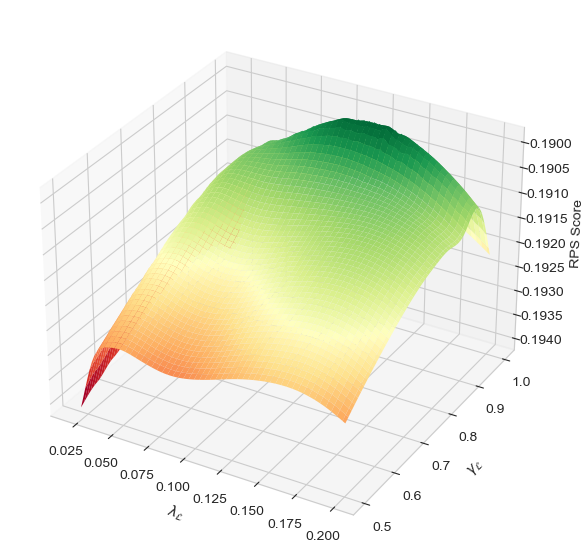

In [68]:
df_gs_results2 = pd.read_csv("../data/gs_resultslam2gam2_fullrange.csv")

# Define grid of x, y values
lambda2_range = np.linspace(0.02, 0.2, num=100)
gamma2_range = np.linspace(0.5, 1.0, num=100)
lambda2_grid, gamma2_grid = np.meshgrid(lambda2_range, gamma2_range)

# Interpolate z values for this grid
rps2_grid = griddata((df_gs_results2['lambda2'], df_gs_results2['gamma2']), df_gs_results2['score'], (lambda2_grid, gamma2_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda2_grid, gamma2_grid, rps2_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\lambda_{\mathcal{L}}$')
ax.set_ylabel(r'$\gamma_{\mathcal{L}}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_l2g2.png", dpi=300)
plt.show()


In [43]:
# Gridsearch on sigma and rho

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'tau': 0.001,
    'ind_threshold': 6000,
    'lambda2': 0.13,
    'gamma2': 0.96,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'rho': np.linspace(0.0, 1.5, 16),
    'sigma': np.linspace(0.0, 1.5, 16)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results3 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results3.append({
        'rho': rates['rho'],
        'sigma': rates['sigma'],
        'score': score,
    })
    
    print(f"rho: {rates['rho']}, sigma: {rates['sigma']}, Score: {score}")


  1%|          | 2/256 [00:00<00:21, 11.64it/s]

RPS for INT1: 0.232687417647728 

rho: 0.0, sigma: 0.0, Score: 0.232687417647728
RPS for INT1: 0.2242823645254441 

rho: 0.0, sigma: 0.1, Score: 0.2242823645254441
RPS for INT1: 0.21722881395192858 

rho: 0.0, sigma: 0.2, Score: 0.21722881395192858


  2%|▏         | 6/256 [00:00<00:21, 11.44it/s]

RPS for INT1: 0.21154748073604304 

rho: 0.0, sigma: 0.30000000000000004, Score: 0.21154748073604304
RPS for INT1: 0.20718752285092404 

rho: 0.0, sigma: 0.4, Score: 0.20718752285092404
RPS for INT1: 0.20404470028460417 

rho: 0.0, sigma: 0.5, Score: 0.20404470028460417


  3%|▎         | 8/256 [00:00<00:22, 11.26it/s]

RPS for INT1: 0.20198216986377285 

rho: 0.0, sigma: 0.6000000000000001, Score: 0.20198216986377285
RPS for INT1: 0.20084935942149873 

rho: 0.0, sigma: 0.7000000000000001, Score: 0.20084935942149873
RPS for INT1: 0.2004964086349719 

rho: 0.0, sigma: 0.8, Score: 0.2004964086349719
RPS for INT1: 0.20078359205538096 

rho: 0.0, sigma: 0.9, Score: 0.20078359205538096


  5%|▍         | 12/256 [00:01<00:21, 11.27it/s]

RPS for INT1: 0.20158638006756957 

rho: 0.0, sigma: 1.0, Score: 0.20158638006756957
RPS for INT1: 0.2027972956179952 

rho: 0.0, sigma: 1.1, Score: 0.2027972956179952
RPS for INT1: 0.20432571972371083 

rho: 0.0, sigma: 1.2000000000000002, Score: 0.20432571972371083


  6%|▋         | 16/256 [00:01<00:21, 11.19it/s]

RPS for INT1: 0.206096558575636 

rho: 0.0, sigma: 1.3, Score: 0.206096558575636
RPS for INT1: 0.20804839876528466 

rho: 0.0, sigma: 1.4000000000000001, Score: 0.20804839876528466
RPS for INT1: 0.21013153575450833 

rho: 0.0, sigma: 1.5, Score: 0.21013153575450833


  7%|▋         | 18/256 [00:01<00:21, 11.12it/s]

RPS for INT1: 0.22802782605748742 

rho: 0.1, sigma: 0.0, Score: 0.22802782605748742
RPS for INT1: 0.21993127975486496 

rho: 0.1, sigma: 0.1, Score: 0.21993127975486496
RPS for INT1: 0.2131886558801093 

rho: 0.1, sigma: 0.2, Score: 0.2131886558801093
RPS for INT1: 0.20781223550593753 

rho: 0.1, sigma: 0.30000000000000004, Score: 0.20781223550593753


  9%|▊         | 22/256 [00:01<00:20, 11.23it/s]

RPS for INT1: 0.20374454378439733 

rho: 0.1, sigma: 0.4, Score: 0.20374454378439733
RPS for INT1: 0.20087637732087288 

rho: 0.1, sigma: 0.5, Score: 0.20087637732087288
RPS for INT1: 0.1990674280376098 

rho: 0.1, sigma: 0.6000000000000001, Score: 0.1990674280376098


 10%|█         | 26/256 [00:02<00:20, 11.05it/s]

RPS for INT1: 0.19816501970794398 

rho: 0.1, sigma: 0.7000000000000001, Score: 0.19816501970794398
RPS for INT1: 0.19801842521071614 

rho: 0.1, sigma: 0.8, Score: 0.19801842521071614
RPS for INT1: 0.19848813509693997 

rho: 0.1, sigma: 0.9, Score: 0.19848813509693997


 11%|█         | 28/256 [00:02<00:20, 11.00it/s]

RPS for INT1: 0.19945071265239442 

rho: 0.1, sigma: 1.0, Score: 0.19945071265239442
RPS for INT1: 0.20080040729368437 

rho: 0.1, sigma: 1.1, Score: 0.20080040729368437
RPS for INT1: 0.20244871205073758 

rho: 0.1, sigma: 1.2000000000000002, Score: 0.20244871205073758
RPS for INT1: 0.2043228098547218 

rho: 0.1, sigma: 1.3, Score: 0.2043228098547218


 12%|█▎        | 32/256 [00:02<00:20, 10.91it/s]

RPS for INT1: 0.20636355502390202 

rho: 0.1, sigma: 1.4000000000000001, Score: 0.20636355502390202
RPS for INT1: 0.2085233810486528 

rho: 0.1, sigma: 1.5, Score: 0.2085233810486528
RPS for INT1: 0.2238915348882139 

rho: 0.2, sigma: 0.0, Score: 0.2238915348882139


 14%|█▍        | 36/256 [00:03<00:20, 10.79it/s]

RPS for INT1: 0.21612028543572392 

rho: 0.2, sigma: 0.1, Score: 0.21612028543572392
RPS for INT1: 0.2096909145761411 

rho: 0.2, sigma: 0.2, Score: 0.2096909145761411
RPS for INT1: 0.20460850946113027 

rho: 0.2, sigma: 0.30000000000000004, Score: 0.20460850946113027


 15%|█▍        | 38/256 [00:03<00:20, 10.71it/s]

RPS for INT1: 0.20081117893867245 

rho: 0.2, sigma: 0.4, Score: 0.20081117893867245
RPS for INT1: 0.19818750255872572 

rho: 0.2, sigma: 0.5, Score: 0.19818750255872572
RPS for INT1: 0.19659654949933617 

rho: 0.2, sigma: 0.6000000000000001, Score: 0.19659654949933617


 16%|█▋        | 42/256 [00:03<00:20, 10.51it/s]

RPS for INT1: 0.19588613963690393 

rho: 0.2, sigma: 0.7000000000000001, Score: 0.19588613963690393
RPS for INT1: 0.1959068312137729 

rho: 0.2, sigma: 0.8, Score: 0.1959068312137729
RPS for INT1: 0.1965209547684684 

rho: 0.2, sigma: 0.9, Score: 0.1965209547684684


 17%|█▋        | 44/256 [00:04<00:20, 10.57it/s]

RPS for INT1: 0.19760727711445406 

rho: 0.2, sigma: 1.0, Score: 0.19760727711445406
RPS for INT1: 0.19906244320725597 

rho: 0.2, sigma: 1.1, Score: 0.19906244320725597
RPS for INT1: 0.2008003812320442 

rho: 0.2, sigma: 1.2000000000000002, Score: 0.2008003812320442
RPS for INT1: 0.20275062430385543 

rho: 0.2, sigma: 1.3, Score: 0.20275062430385543


 19%|█▉        | 48/256 [00:04<00:19, 10.63it/s]

RPS for INT1: 0.20485620191200993 

rho: 0.2, sigma: 1.4000000000000001, Score: 0.20485620191200993
RPS for INT1: 0.20707149295704047 

rho: 0.2, sigma: 1.5, Score: 0.20707149295704047
RPS for INT1: 0.2202911168608037 

rho: 0.30000000000000004, sigma: 0.0, Score: 0.2202911168608037


 20%|██        | 52/256 [00:04<00:19, 10.38it/s]

RPS for INT1: 0.21285383634428018 

rho: 0.30000000000000004, sigma: 0.1, Score: 0.21285383634428018
RPS for INT1: 0.20673274459292065 

rho: 0.30000000000000004, sigma: 0.2, Score: 0.20673274459292065
RPS for INT1: 0.20192746579997387 

rho: 0.30000000000000004, sigma: 0.30000000000000004, Score: 0.20192746579997387


 21%|██        | 54/256 [00:04<00:19, 10.33it/s]

RPS for INT1: 0.1983741735635825 

rho: 0.30000000000000004, sigma: 0.4, Score: 0.1983741735635825
RPS for INT1: 0.19596202303797006 

rho: 0.30000000000000004, sigma: 0.5, Score: 0.19596202303797006
RPS for INT1: 0.19455217168354305 

rho: 0.30000000000000004, sigma: 0.6000000000000001, Score: 0.19455217168354305


 23%|██▎       | 58/256 [00:05<00:19, 10.42it/s]

RPS for INT1: 0.19399528458572088 

rho: 0.30000000000000004, sigma: 0.7000000000000001, Score: 0.19399528458572088
RPS for INT1: 0.19414504749949693 

rho: 0.30000000000000004, sigma: 0.8, Score: 0.19414504749949693
RPS for INT1: 0.1948669395987723 

rho: 0.30000000000000004, sigma: 0.9, Score: 0.1948669395987723


 23%|██▎       | 60/256 [00:05<00:18, 10.38it/s]

RPS for INT1: 0.1960427603677845 

rho: 0.30000000000000004, sigma: 1.0, Score: 0.1960427603677845
RPS for INT1: 0.19757199396671887 

rho: 0.30000000000000004, sigma: 1.1, Score: 0.19757199396671887
RPS for INT1: 0.19937116451415493 

rho: 0.30000000000000004, sigma: 1.2000000000000002, Score: 0.19937116451415493


 25%|██▌       | 64/256 [00:05<00:18, 10.54it/s]

RPS for INT1: 0.20137212535777574 

rho: 0.30000000000000004, sigma: 1.3, Score: 0.20137212535777574
RPS for INT1: 0.20351993391674805 

rho: 0.30000000000000004, sigma: 1.4000000000000001, Score: 0.20351993391674805
RPS for INT1: 0.20577070351099566 

rho: 0.30000000000000004, sigma: 1.5, Score: 0.20577070351099566


 26%|██▌       | 66/256 [00:06<00:18, 10.55it/s]

RPS for INT1: 0.21722755921287212 

rho: 0.4, sigma: 0.0, Score: 0.21722755921287212
RPS for INT1: 0.21012518128050103 

rho: 0.4, sigma: 0.1, Score: 0.21012518128050103
RPS for INT1: 0.2043010935133755 

rho: 0.4, sigma: 0.2, Score: 0.2043010935133755
RPS for INT1: 0.1997515045732215 

rho: 0.4, sigma: 0.30000000000000004, Score: 0.1997515045732215


 27%|██▋       | 70/256 [00:06<00:17, 10.59it/s]

RPS for INT1: 0.19641319434650045 

rho: 0.4, sigma: 0.4, Score: 0.19641319434650045
RPS for INT1: 0.19417853946655603 

rho: 0.4, sigma: 0.5, Score: 0.19417853946655603
RPS for INT1: 0.192913212752635 

rho: 0.4, sigma: 0.6000000000000001, Score: 0.192913212752635


 29%|██▉       | 74/256 [00:06<00:17, 10.36it/s]

RPS for INT1: 0.19247272388298733 

rho: 0.4, sigma: 0.7000000000000001, Score: 0.19247272388298733
RPS for INT1: 0.19271537271394407 

rho: 0.4, sigma: 0.8, Score: 0.19271537271394407
RPS for INT1: 0.19351077676185965 

rho: 0.4, sigma: 0.9, Score: 0.19351077676185965


 30%|██▉       | 76/256 [00:07<00:17, 10.36it/s]

RPS for INT1: 0.19474433905066926 

rho: 0.4, sigma: 1.0, Score: 0.19474433905066926
RPS for INT1: 0.19631863715502762 

rho: 0.4, sigma: 1.1, Score: 0.19631863715502762
RPS for INT1: 0.19815282791144714 

rho: 0.4, sigma: 1.2000000000000002, Score: 0.19815282791144714


 31%|███▏      | 80/256 [00:07<00:16, 10.38it/s]

RPS for INT1: 0.20018098633118245 

rho: 0.4, sigma: 1.3, Score: 0.20018098633118245
RPS for INT1: 0.20235002452494175 

rho: 0.4, sigma: 1.4000000000000001, Score: 0.20235002452494175
RPS for INT1: 0.2046175832613951 

rho: 0.4, sigma: 1.5, Score: 0.2046175832613951


 32%|███▏      | 82/256 [00:07<00:17, 10.21it/s]

RPS for INT1: 0.21469119033354087 

rho: 0.5, sigma: 0.0, Score: 0.21469119033354087
RPS for INT1: 0.20791766388731153 

rho: 0.5, sigma: 0.1, Score: 0.20791766388731153
RPS for INT1: 0.2023742141314596 

rho: 0.5, sigma: 0.2, Score: 0.2023742141314596


 33%|███▎      | 85/256 [00:07<00:17,  9.62it/s]

RPS for INT1: 0.19805580964921957 

rho: 0.5, sigma: 0.30000000000000004, Score: 0.19805580964921957
RPS for INT1: 0.19490225385379178 

rho: 0.5, sigma: 0.4, Score: 0.19490225385379178
RPS for INT1: 0.19281149320318505 

rho: 0.5, sigma: 0.5, Score: 0.19281149320318505


 34%|███▍      | 88/256 [00:08<00:19,  8.75it/s]

RPS for INT1: 0.1916557582317416 

rho: 0.5, sigma: 0.6000000000000001, Score: 0.1916557582317416
RPS for INT1: 0.1912970034886657 

rho: 0.5, sigma: 0.7000000000000001, Score: 0.1912970034886657
RPS for INT1: 0.1915992665970147 

rho: 0.5, sigma: 0.8, Score: 0.1915992665970147


 36%|███▌      | 91/256 [00:08<00:19,  8.54it/s]

RPS for INT1: 0.19243699439569822 

rho: 0.5, sigma: 0.9, Score: 0.19243699439569822
RPS for INT1: 0.19369953956618566 

rho: 0.5, sigma: 1.0, Score: 0.19369953956618566
RPS for INT1: 0.1952926738144888 

rho: 0.5, sigma: 1.1, Score: 0.1952926738144888


 37%|███▋      | 94/256 [00:09<00:17,  9.23it/s]

RPS for INT1: 0.1971381313893617 

rho: 0.5, sigma: 1.2000000000000002, Score: 0.1971381313893617
RPS for INT1: 0.19917206691988174 

rho: 0.5, sigma: 1.3, Score: 0.19917206691988174
RPS for INT1: 0.20134306622535617 

rho: 0.5, sigma: 1.4000000000000001, Score: 0.20134306622535617


 38%|███▊      | 97/256 [00:09<00:16,  9.55it/s]

RPS for INT1: 0.20361010716471972 

rho: 0.5, sigma: 1.5, Score: 0.20361010716471972
RPS for INT1: 0.2126631181911061 

rho: 0.6000000000000001, sigma: 0.0, Score: 0.2126631181911061
RPS for INT1: 0.2062064397054075 

rho: 0.6000000000000001, sigma: 0.1, Score: 0.2062064397054075


 39%|███▉      | 100/256 [00:09<00:16,  9.74it/s]

RPS for INT1: 0.20092346767053063 

rho: 0.6000000000000001, sigma: 0.2, Score: 0.20092346767053063
RPS for INT1: 0.19681005792767323 

rho: 0.6000000000000001, sigma: 0.30000000000000004, Score: 0.19681005792767323


 40%|████      | 103/256 [00:10<00:17,  8.58it/s]

RPS for INT1: 0.1938111860153829 

rho: 0.6000000000000001, sigma: 0.4, Score: 0.1938111860153829
RPS for INT1: 0.19183232257130303 

rho: 0.6000000000000001, sigma: 0.5, Score: 0.19183232257130303
RPS for INT1: 0.19075386686128096 

rho: 0.6000000000000001, sigma: 0.6000000000000001, Score: 0.19075386686128096


 41%|████▏     | 106/256 [00:10<00:15,  9.42it/s]

RPS for INT1: 0.19044541420655572 

rho: 0.6000000000000001, sigma: 0.7000000000000001, Score: 0.19044541420655572
RPS for INT1: 0.1907775229655833 

rho: 0.6000000000000001, sigma: 0.8, Score: 0.1907775229655833
RPS for INT1: 0.19162989700199148 

rho: 0.6000000000000001, sigma: 0.9, Score: 0.19162989700199148


 43%|████▎     | 109/256 [00:10<00:15,  9.79it/s]

RPS for INT1: 0.19289599738495045 

rho: 0.6000000000000001, sigma: 1.0, Score: 0.19289599738495045
RPS for INT1: 0.19448476944705873 

rho: 0.6000000000000001, sigma: 1.1, Score: 0.19448476944705873
RPS for INT1: 0.1963204016097953 

rho: 0.6000000000000001, sigma: 1.2000000000000002, Score: 0.1963204016097953


 43%|████▎     | 111/256 [00:10<00:14, 10.04it/s]

RPS for INT1: 0.19834095845702795 

rho: 0.6000000000000001, sigma: 1.3, Score: 0.19834095845702795
RPS for INT1: 0.200496519754774 

rho: 0.6000000000000001, sigma: 1.4000000000000001, Score: 0.200496519754774
RPS for INT1: 0.2027472307795427 

rho: 0.6000000000000001, sigma: 1.5, Score: 0.2027472307795427


 45%|████▍     | 115/256 [00:11<00:13, 10.36it/s]

RPS for INT1: 0.21111699720355073 

rho: 0.7000000000000001, sigma: 0.0, Score: 0.21111699720355073
RPS for INT1: 0.20496041144575522 

rho: 0.7000000000000001, sigma: 0.1, Score: 0.20496041144575522
RPS for INT1: 0.19991523473998155 

rho: 0.7000000000000001, sigma: 0.2, Score: 0.19991523473998155


 46%|████▌     | 117/256 [00:11<00:13, 10.47it/s]

RPS for INT1: 0.19598014555310753 

rho: 0.7000000000000001, sigma: 0.30000000000000004, Score: 0.19598014555310753
RPS for INT1: 0.1931070781903922 

rho: 0.7000000000000001, sigma: 0.4, Score: 0.1931070781903922
RPS for INT1: 0.1912105464389307 

rho: 0.7000000000000001, sigma: 0.5, Score: 0.1912105464389307
RPS for INT1: 0.19018029913630458 

rho: 0.7000000000000001, sigma: 0.6000000000000001, Score: 0.19018029913630458


 47%|████▋     | 121/256 [00:11<00:12, 10.54it/s]

RPS for INT1: 0.1898943931201459 

rho: 0.7000000000000001, sigma: 0.7000000000000001, Score: 0.1898943931201459
RPS for INT1: 0.19023039217236104 

rho: 0.7000000000000001, sigma: 0.8, Score: 0.19023039217236104
RPS for INT1: 0.19107346523100982 

rho: 0.7000000000000001, sigma: 0.9, Score: 0.19107346523100982


 49%|████▉     | 125/256 [00:12<00:12, 10.63it/s]

RPS for INT1: 0.1923211902664263 

rho: 0.7000000000000001, sigma: 1.0, Score: 0.1923211902664263
RPS for INT1: 0.19388557177042773 

rho: 0.7000000000000001, sigma: 1.1, Score: 0.19388557177042773
RPS for INT1: 0.1956930781959218 

rho: 0.7000000000000001, sigma: 1.2000000000000002, Score: 0.1956930781959218


 50%|████▉     | 127/256 [00:12<00:12, 10.73it/s]

RPS for INT1: 0.197683495117083 

rho: 0.7000000000000001, sigma: 1.3, Score: 0.197683495117083
RPS for INT1: 0.19980821954946065 

rho: 0.7000000000000001, sigma: 1.4000000000000001, Score: 0.19980821954946065
RPS for INT1: 0.20202841285085946 

rho: 0.7000000000000001, sigma: 1.5, Score: 0.20202841285085946
RPS for INT1: 0.21002093397933141 

rho: 0.8, sigma: 0.0, Score: 0.21002093397933141


 51%|█████     | 131/256 [00:12<00:11, 10.68it/s]

RPS for INT1: 0.2041441941273915 

rho: 0.8, sigma: 0.1, Score: 0.2041441941273915
RPS for INT1: 0.19931277205226747 

rho: 0.8, sigma: 0.2, Score: 0.19931277205226747
RPS for INT1: 0.1955298116397982 

rho: 0.8, sigma: 0.30000000000000004, Score: 0.1955298116397982


 53%|█████▎    | 135/256 [00:13<00:11, 10.83it/s]

RPS for INT1: 0.19275558829514114 

rho: 0.8, sigma: 0.4, Score: 0.19275558829514114
RPS for INT1: 0.19091474813378384 

rho: 0.8, sigma: 0.5, Score: 0.19091474813378384
RPS for INT1: 0.18990717750210473 

rho: 0.8, sigma: 0.6000000000000001, Score: 0.18990717750210473


 54%|█████▎    | 137/256 [00:13<00:11, 10.80it/s]

RPS for INT1: 0.1896198927429435 

rho: 0.8, sigma: 0.7000000000000001, Score: 0.1896198927429435
RPS for INT1: 0.18993770355109552 

rho: 0.8, sigma: 0.8, Score: 0.18993770355109552
RPS for INT1: 0.19075127916444345 

rho: 0.8, sigma: 0.9, Score: 0.19075127916444345
RPS for INT1: 0.19196220789847646 

rho: 0.8, sigma: 1.0, Score: 0.19196220789847646


 55%|█████▌    | 141/256 [00:13<00:10, 10.78it/s]

RPS for INT1: 0.19348536761378887 

rho: 0.8, sigma: 1.1, Score: 0.19348536761378887
RPS for INT1: 0.1952492933483875 

rho: 0.8, sigma: 1.2000000000000002, Score: 0.1952492933483875
RPS for INT1: 0.19719528645989373 

rho: 0.8, sigma: 1.3, Score: 0.19719528645989373


 57%|█████▋    | 145/256 [00:13<00:10, 10.87it/s]

RPS for INT1: 0.1992758847434317 

rho: 0.8, sigma: 1.4000000000000001, Score: 0.1992758847434317
RPS for INT1: 0.201453126196453 

rho: 0.8, sigma: 1.5, Score: 0.201453126196453
RPS for INT1: 0.20933936236132492 

rho: 0.9, sigma: 0.0, Score: 0.20933936236132492


 57%|█████▋    | 147/256 [00:14<00:10, 10.82it/s]

RPS for INT1: 0.20371995458139802 

rho: 0.9, sigma: 0.1, Score: 0.20371995458139802
RPS for INT1: 0.1990778900741857 

rho: 0.9, sigma: 0.2, Score: 0.1990778900741857
RPS for INT1: 0.19542207281659743 

rho: 0.9, sigma: 0.30000000000000004, Score: 0.19542207281659743
RPS for INT1: 0.19272209786425143 

rho: 0.9, sigma: 0.4, Score: 0.19272209786425143


 59%|█████▉    | 151/256 [00:14<00:09, 10.79it/s]

RPS for INT1: 0.19091344239546712 

rho: 0.9, sigma: 0.5, Score: 0.19091344239546712
RPS for INT1: 0.18990658495394247 

rho: 0.9, sigma: 0.6000000000000001, Score: 0.18990658495394247
RPS for INT1: 0.18959774116597758 

rho: 0.9, sigma: 0.7000000000000001, Score: 0.18959774116597758


 61%|██████    | 155/256 [00:14<00:09, 10.84it/s]

RPS for INT1: 0.18987902166361667 

rho: 0.9, sigma: 0.8, Score: 0.18987902166361667
RPS for INT1: 0.19064650526523902 

rho: 0.9, sigma: 0.9, Score: 0.19064650526523902
RPS for INT1: 0.1918056018584756 

rho: 0.9, sigma: 1.0, Score: 0.1918056018584756


 61%|██████▏   | 157/256 [00:15<00:09, 10.94it/s]

RPS for INT1: 0.19327382501160095 

rho: 0.9, sigma: 1.1, Score: 0.19327382501160095
RPS for INT1: 0.19498153193271353 

rho: 0.9, sigma: 1.2000000000000002, Score: 0.19498153193271353
RPS for INT1: 0.19687131844312197 

rho: 0.9, sigma: 1.3, Score: 0.19687131844312197
RPS for INT1: 0.19889668157899906 

rho: 0.9, sigma: 1.4000000000000001, Score: 0.19889668157899906


 63%|██████▎   | 161/256 [00:15<00:08, 10.90it/s]

RPS for INT1: 0.20102039996054427 

rho: 0.9, sigma: 1.5, Score: 0.20102039996054427
RPS for INT1: 0.20903475606210173 

rho: 1.0, sigma: 0.0, Score: 0.20903475606210173
RPS for INT1: 0.20364901569440835 

rho: 1.0, sigma: 0.1, Score: 0.20364901569440835


 64%|██████▍   | 165/256 [00:15<00:08, 10.77it/s]

RPS for INT1: 0.19917237063454624 

rho: 1.0, sigma: 0.2, Score: 0.19917237063454624
RPS for INT1: 0.1956204157977724 

rho: 1.0, sigma: 0.30000000000000004, Score: 0.1956204157977724
RPS for INT1: 0.19297267178477875 

rho: 1.0, sigma: 0.4, Score: 0.19297267178477875


 65%|██████▌   | 167/256 [00:16<00:08, 10.70it/s]

RPS for INT1: 0.19117581368201322 

rho: 1.0, sigma: 0.5, Score: 0.19117581368201322
RPS for INT1: 0.19015110261169807 

rho: 1.0, sigma: 0.6000000000000001, Score: 0.19015110261169807
RPS for INT1: 0.18980400214379956 

rho: 1.0, sigma: 0.7000000000000001, Score: 0.18980400214379956


 67%|██████▋   | 171/256 [00:16<00:08, 10.61it/s]

RPS for INT1: 0.1900338512208025 

rho: 1.0, sigma: 0.8, Score: 0.1900338512208025
RPS for INT1: 0.1907419664507638 

rho: 1.0, sigma: 0.9, Score: 0.1907419664507638
RPS for INT1: 0.191837339294399 

rho: 1.0, sigma: 1.0, Score: 0.191837339294399


 68%|██████▊   | 173/256 [00:16<00:08, 10.28it/s]

RPS for INT1: 0.19323984757943183 

rho: 1.0, sigma: 1.1, Score: 0.19323984757943183
RPS for INT1: 0.1948814026725018 

rho: 1.0, sigma: 1.2000000000000002, Score: 0.1948814026725018
RPS for INT1: 0.19670565682930907 

rho: 1.0, sigma: 1.3, Score: 0.19670565682930907


 69%|██████▉   | 177/256 [00:16<00:07, 10.47it/s]

RPS for INT1: 0.19866687384871903 

rho: 1.0, sigma: 1.4000000000000001, Score: 0.19866687384871903
RPS for INT1: 0.20072843147070382 

rho: 1.0, sigma: 1.5, Score: 0.20072843147070382
RPS for INT1: 0.20906909292204945 

rho: 1.1, sigma: 0.0, Score: 0.20906909292204945


 70%|██████▉   | 179/256 [00:17<00:07, 10.52it/s]

RPS for INT1: 0.20389316442831285 

rho: 1.1, sigma: 0.1, Score: 0.20389316442831285
RPS for INT1: 0.19955908619295795 

rho: 1.1, sigma: 0.2, Score: 0.19955908619295795
RPS for INT1: 0.19608972607243746 

rho: 1.1, sigma: 0.30000000000000004, Score: 0.19608972607243746
RPS for INT1: 0.19347481237833242 

rho: 1.1, sigma: 0.4, Score: 0.19347481237833242


 71%|███████▏  | 183/256 [00:17<00:06, 10.60it/s]

RPS for INT1: 0.19167231800891368 

rho: 1.1, sigma: 0.5, Score: 0.19167231800891368
RPS for INT1: 0.19061428034690403 

rho: 1.1, sigma: 0.6000000000000001, Score: 0.19061428034690403
RPS for INT1: 0.19021533057185502 

rho: 1.1, sigma: 0.7000000000000001, Score: 0.19021533057185502


 73%|███████▎  | 187/256 [00:17<00:06, 10.65it/s]

RPS for INT1: 0.19038188816359175 

rho: 1.1, sigma: 0.8, Score: 0.19038188816359175
RPS for INT1: 0.19102029580845314 

rho: 1.1, sigma: 0.9, Score: 0.19102029580845314
RPS for INT1: 0.19204286472805998 

rho: 1.1, sigma: 1.0, Score: 0.19204286472805998


 74%|███████▍  | 189/256 [00:18<00:06, 10.59it/s]

RPS for INT1: 0.1933715500221644 

rho: 1.1, sigma: 1.1, Score: 0.1933715500221644
RPS for INT1: 0.19493953408700215 

rho: 1.1, sigma: 1.2000000000000002, Score: 0.19493953408700215
RPS for INT1: 0.19669127159609467 

rho: 1.1, sigma: 1.3, Score: 0.19669127159609467


 75%|███████▌  | 193/256 [00:18<00:05, 10.56it/s]

RPS for INT1: 0.19858158493287062 

rho: 1.1, sigma: 1.4000000000000001, Score: 0.19858158493287062
RPS for INT1: 0.2005742958674161 

rho: 1.1, sigma: 1.5, Score: 0.2005742958674161
RPS for INT1: 0.20940502944242873 

rho: 1.2000000000000002, sigma: 0.0, Score: 0.20940502944242873


 76%|███████▌  | 195/256 [00:18<00:05, 10.37it/s]

RPS for INT1: 0.20441564600842935 

rho: 1.2000000000000002, sigma: 0.1, Score: 0.20441564600842935
RPS for INT1: 0.20020281847667792 

rho: 1.2000000000000002, sigma: 0.2, Score: 0.20020281847667792
RPS for INT1: 0.19679695625461288 

rho: 1.2000000000000002, sigma: 0.30000000000000004, Score: 0.19679695625461288


 78%|███████▊  | 199/256 [00:19<00:05, 10.49it/s]

RPS for INT1: 0.19419800973630186 

rho: 1.2000000000000002, sigma: 0.4, Score: 0.19419800973630186
RPS for INT1: 0.19237514457594834 

rho: 1.2000000000000002, sigma: 0.5, Score: 0.19237514457594834
RPS for INT1: 0.19127103047075095 

rho: 1.2000000000000002, sigma: 0.6000000000000001, Score: 0.19127103047075095


 79%|███████▊  | 201/256 [00:19<00:05, 10.46it/s]

RPS for INT1: 0.19080930893397818 

rho: 1.2000000000000002, sigma: 0.7000000000000001, Score: 0.19080930893397818
RPS for INT1: 0.19090330095420677 

rho: 1.2000000000000002, sigma: 0.8, Score: 0.19090330095420677
RPS for INT1: 0.19146415931770341 

rho: 1.2000000000000002, sigma: 0.9, Score: 0.19146415931770341


 80%|████████  | 205/256 [00:19<00:04, 10.56it/s]

RPS for INT1: 0.19240725877060028 

rho: 1.2000000000000002, sigma: 1.0, Score: 0.19240725877060028
RPS for INT1: 0.19365634821972344 

rho: 1.2000000000000002, sigma: 1.1, Score: 0.19365634821972344
RPS for INT1: 0.19514559383092261 

rho: 1.2000000000000002, sigma: 1.2000000000000002, Score: 0.19514559383092261


 81%|████████  | 207/256 [00:19<00:04, 10.51it/s]

RPS for INT1: 0.19681998644869153 

rho: 1.2000000000000002, sigma: 1.3, Score: 0.19681998644869153
RPS for INT1: 0.1986346811244241 

rho: 1.2000000000000002, sigma: 1.4000000000000001, Score: 0.1986346811244241
RPS for INT1: 0.2005537689119499 

rho: 1.2000000000000002, sigma: 1.5, Score: 0.2005537689119499


 82%|████████▏ | 211/256 [00:20<00:04, 10.47it/s]

RPS for INT1: 0.21000678139142637 

rho: 1.3, sigma: 0.0, Score: 0.21000678139142637
RPS for INT1: 0.20518185985410684 

rho: 1.3, sigma: 0.1, Score: 0.20518185985410684
RPS for INT1: 0.20107080060803362 

rho: 1.3, sigma: 0.2, Score: 0.20107080060803362


 83%|████████▎ | 213/256 [00:20<00:04, 10.55it/s]

RPS for INT1: 0.1977115565023956 

rho: 1.3, sigma: 0.30000000000000004, Score: 0.1977115565023956
RPS for INT1: 0.19511410188681483 

rho: 1.3, sigma: 0.4, Score: 0.19511410188681483
RPS for INT1: 0.1932585387069401 

rho: 1.3, sigma: 0.5, Score: 0.1932585387069401


 85%|████████▍ | 217/256 [00:20<00:03, 10.49it/s]

RPS for INT1: 0.19209793425718827 

rho: 1.3, sigma: 0.6000000000000001, Score: 0.19209793425718827
RPS for INT1: 0.19156474553981476 

rho: 1.3, sigma: 0.7000000000000001, Score: 0.19156474553981476
RPS for INT1: 0.19157901795271848 

rho: 1.3, sigma: 0.8, Score: 0.19157901795271848


 86%|████████▌ | 219/256 [00:20<00:03, 10.53it/s]

RPS for INT1: 0.1920565225426997 

rho: 1.3, sigma: 0.9, Score: 0.1920565225426997
RPS for INT1: 0.19291547101764317 

rho: 1.3, sigma: 1.0, Score: 0.19291547101764317
RPS for INT1: 0.19408114547916872 

rho: 1.3, sigma: 1.1, Score: 0.19408114547916872
RPS for INT1: 0.19548841825538754 

rho: 1.3, sigma: 1.2000000000000002, Score: 0.19548841825538754


 87%|████████▋ | 223/256 [00:21<00:03, 10.52it/s]

RPS for INT1: 0.1970825456759726 

rho: 1.3, sigma: 1.3, Score: 0.1970825456759726
RPS for INT1: 0.19881877385934502 

rho: 1.3, sigma: 1.4000000000000001, Score: 0.19881877385934502
RPS for INT1: 0.20066126602859027 

rho: 1.3, sigma: 1.5, Score: 0.20066126602859027


 89%|████████▊ | 227/256 [00:21<00:02, 10.25it/s]

RPS for INT1: 0.21084073284263613 

rho: 1.4000000000000001, sigma: 0.0, Score: 0.21084073284263613
RPS for INT1: 0.206159794221872 

rho: 1.4000000000000001, sigma: 0.1, Score: 0.206159794221872
RPS for INT1: 0.2021330230746451 

rho: 1.4000000000000001, sigma: 0.2, Score: 0.2021330230746451


 89%|████████▉ | 229/256 [00:21<00:02, 10.31it/s]

RPS for INT1: 0.19880570148947066 

rho: 1.4000000000000001, sigma: 0.30000000000000004, Score: 0.19880570148947066
RPS for INT1: 0.1961974673051133 

rho: 1.4000000000000001, sigma: 0.4, Score: 0.1961974673051133
RPS for INT1: 0.19429899390555588 

rho: 1.4000000000000001, sigma: 0.5, Score: 0.19429899390555588


 90%|█████████ | 231/256 [00:22<00:02, 10.19it/s]

RPS for INT1: 0.193073454646854 

rho: 1.4000000000000001, sigma: 0.6000000000000001, Score: 0.193073454646854
RPS for INT1: 0.19246191597030055 

rho: 1.4000000000000001, sigma: 0.7000000000000001, Score: 0.19246191597030055
RPS for INT1: 0.19239099428971648 

rho: 1.4000000000000001, sigma: 0.8, Score: 0.19239099428971648


 92%|█████████▏| 235/256 [00:22<00:02,  9.96it/s]

RPS for INT1: 0.19278093106253447 

rho: 1.4000000000000001, sigma: 0.9, Score: 0.19278093106253447
RPS for INT1: 0.19355259718771925 

rho: 1.4000000000000001, sigma: 1.0, Score: 0.19355259718771925
RPS for INT1: 0.19463258821707435 

rho: 1.4000000000000001, sigma: 1.1, Score: 0.19463258821707435


 93%|█████████▎| 237/256 [00:22<00:01, 10.00it/s]

RPS for INT1: 0.19595623027440354 

rho: 1.4000000000000001, sigma: 1.2000000000000002, Score: 0.19595623027440354
RPS for INT1: 0.1974687817459482 

rho: 1.4000000000000001, sigma: 1.3, Score: 0.1974687817459482
RPS for INT1: 0.19912532936985172 

rho: 1.4000000000000001, sigma: 1.4000000000000001, Score: 0.19912532936985172


 94%|█████████▍| 241/256 [00:23<00:01, 10.00it/s]

RPS for INT1: 0.2008898908930136 

rho: 1.4000000000000001, sigma: 1.5, Score: 0.2008898908930136
RPS for INT1: 0.21187581171962314 

rho: 1.5, sigma: 0.0, Score: 0.21187581171962314
RPS for INT1: 0.20732024704610275 

rho: 1.5, sigma: 0.1, Score: 0.20732024704610275


 96%|█████████▌| 245/256 [00:23<00:01, 10.12it/s]

RPS for INT1: 0.2033623510312091 

rho: 1.5, sigma: 0.2, Score: 0.2033623510312091
RPS for INT1: 0.20005435420977977 

rho: 1.5, sigma: 0.30000000000000004, Score: 0.20005435420977977
RPS for INT1: 0.19742507812703727 

rho: 1.5, sigma: 0.4, Score: 0.19742507812703727


 96%|█████████▋| 247/256 [00:23<00:00, 10.12it/s]

RPS for INT1: 0.1954753271078722 

rho: 1.5, sigma: 0.5, Score: 0.1954753271078722
RPS for INT1: 0.1941780546508405 

rho: 1.5, sigma: 0.6000000000000001, Score: 0.1941780546508405
RPS for INT1: 0.19348273417265852 

rho: 1.5, sigma: 0.7000000000000001, Score: 0.19348273417265852


 98%|█████████▊| 251/256 [00:24<00:00, 10.18it/s]

RPS for INT1: 0.1933224344760495 

rho: 1.5, sigma: 0.8, Score: 0.1933224344760495
RPS for INT1: 0.19362177443888168 

rho: 1.5, sigma: 0.9, Score: 0.19362177443888168
RPS for INT1: 0.19430416785712426 

rho: 1.5, sigma: 1.0, Score: 0.19430416785712426


 99%|█████████▉| 253/256 [00:24<00:00, 10.15it/s]

RPS for INT1: 0.19529735951930138 

rho: 1.5, sigma: 1.1, Score: 0.19529735951930138
RPS for INT1: 0.19653691761527498 

rho: 1.5, sigma: 1.2000000000000002, Score: 0.19653691761527498
RPS for INT1: 0.19796786063470936 

rho: 1.5, sigma: 1.3, Score: 0.19796786063470936


100%|██████████| 256/256 [00:24<00:00, 10.39it/s]

RPS for INT1: 0.19954486783055045 

rho: 1.5, sigma: 1.4000000000000001, Score: 0.19954486783055045
RPS for INT1: 0.20123158019617335 

rho: 1.5, sigma: 1.5, Score: 0.20123158019617335


In [44]:
# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results3, key=lambda x: x['score'])[:10]

print("Top combinations:")
for combo in top_combinations:
    print(f"rho: {combo['rho']}, sigma: {combo['sigma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results3 = pd.DataFrame(gs_results3)
#to csv
df_gs_results3.to_csv("../data/gs_resultsrhosig.csv", index=False)


Top combinations:
rho: 0.9, sigma: 0.7000000000000001, Score: 0.18959774116597758
rho: 0.8, sigma: 0.7000000000000001, Score: 0.1896198927429435
rho: 1.0, sigma: 0.7000000000000001, Score: 0.18980400214379956
rho: 0.9, sigma: 0.8, Score: 0.18987902166361667
rho: 0.7000000000000001, sigma: 0.7000000000000001, Score: 0.1898943931201459
rho: 0.9, sigma: 0.6000000000000001, Score: 0.18990658495394247
rho: 0.8, sigma: 0.6000000000000001, Score: 0.18990717750210473
rho: 0.8, sigma: 0.8, Score: 0.18993770355109552
rho: 1.0, sigma: 0.8, Score: 0.1900338512208025
rho: 1.0, sigma: 0.6000000000000001, Score: 0.19015110261169807


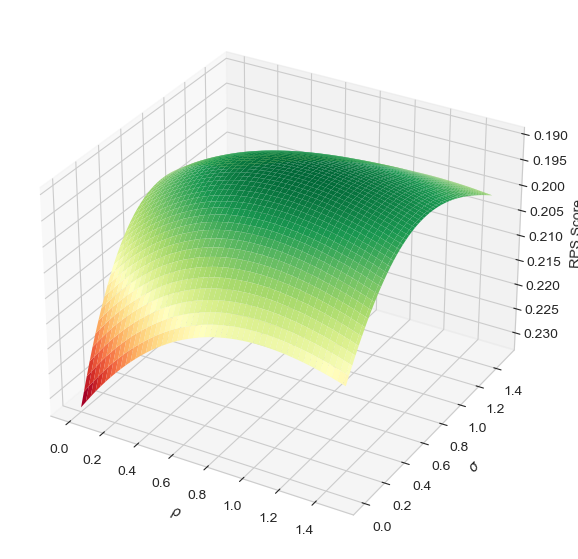

In [69]:
df_gs_results3 = pd.read_csv("../data/gs_resultsrhosig.csv")

# Define grid of x, y values
rho_range = np.linspace(0, 1.5, num=100)
sigma_range = np.linspace(0, 1.5, num=100)
rho_grid, sigma_grid = np.meshgrid(rho_range, sigma_range)

# Interpolate z values for this grid
rps3_grid = griddata((df_gs_results3['rho'], df_gs_results3['sigma']), df_gs_results3['score'], (rho_grid, sigma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(rho_grid, sigma_grid, rps3_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel(r'$\rho}$')
ax.set_ylabel(r'$\sigma}$')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new_rs.png", dpi=300)
plt.show()

In [ ]:
# Gridsearch on int rating

# Define the learning rates
rates = {
    'lambda': 0.043,
    'gamma': 0.98,
    'delta': 2.5,
    'phi': 1,
    'mu': 0.0,
    'rho': 0.9,
    'sigma': 0.7,
    'tau': 0.001,
    'ind_threshold': 6000,
    'lambda2': 0.14,
    'gamma2': 0.96,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda2': np.linspace(0.1, 0.2, 11),
    'gamma2': np.linspace(0.94, 0.98, 5),
    'rho': np.linspace(0.8, 1.0, 5),
    'sigma': np.linspace(0.5, 0.9, 5)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results4 = []

ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)

ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

_, _ = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)

df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)


# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
  
    
        
    int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
   
    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(int_rps)

    score = mean_rps
    
    # Store the current results
    gs_results4.append({
        'lambda2': rates['lambda2'],
        'gamma2': rates['gamma2'],
        'rho': rates['rho'],
        'sigma': rates['sigma'],
        'score': score,
    })
    
    print(f"lambda2: {rates['lambda2']}, gamma2: {rates['gamma2']}, rho: {rates['rho']}, sigma: {rates['sigma']}, Score: {score}")


In [ ]:
# Sort the results based on the score and get the top 5
top_combinations = sorted(gs_results4, key=lambda x: x['score'])[:10]

print("Top combinations:")
for combo in top_combinations:
    print(f"lambda2: {combo['lambda2']}, gamma2: {combo['gamma2']}, rho: {combo['rho']}, sigma: {combo['sigma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results4 = pd.DataFrame(gs_results4)
#to csv
df_gs_results4.to_csv("../data/gs_results_lam2gam2rhosig.csv", index=False)

In [ ]:

# Potential values for lambda2 and gamma2
potential_lambda2_values = np.linspace(0.01, 0.2, num=21)  
potential_gamma2_values = np.linspace(0.9, 1.0, num=11)  

# Lists to hold the parameter 'lambda2', 'gamma2' and the corresponding RPS values
parameter_values = []
rps_values = []

# Iterate over potential lambda2 and gamma2 values
for lambda2 in potential_lambda2_values:
    for gamma2 in potential_gamma2_values:
        _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
        
        # Update rates dictionary with the current lambda2 and gamma2 values
        rates['lambda2'] = lambda2
        rates['gamma2'] = gamma2

        # ... [Your existing code to update ratings and calculate RPS]
        league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
        # Calculate the mean RPS score for this combination
        mean_rps = np.mean(int_rps)
        
        # Store the lambda2, gamma2, and corresponding RPS value
        parameter_values.append((lambda2, gamma2))
        rps_values.append(mean_rps)
        

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (lambda2, gamma2): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:

# Define range for int_threshold
thresholds = np.arange(0, 34000, 2000)  

# Initialize the best_score variable
best_score = float('inf')  

# Create an empty list to store the results
optimization_results = []

for threshold in tqdm.tqdm(thresholds):
    # Update rates with the current threshold
    rates['int_threshold'] = threshold

    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
        
    # Train and evaluate your model with the current threshold
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
        
    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # If the current score is better than the best_score, update best_score
    if score < best_score:
        best_score = score
        best_threshold = threshold

    # Store the current score and threshold
    optimization_results.append({
        'int_threshold': threshold,
        'score': score,
    })
        
    print(f"Threshold: {threshold}, Score: {score}")

# Convert the results to a DataFrame and sort by score
df_optimization_results = pd.DataFrame(optimization_results).sort_values(by='score', ascending=True)

# Display the top 5 combinations of the threshold and their score
print(df_optimization_results.head(10))


print(f"Best int_threshold: {best_threshold}")
print(f"Best score: {best_score}")


In [ ]:
rates = {
    'lambda': 0.04,
    'gamma': 0.96,
    'delta': 1,
    'phi': 1,
    'mu': 0,
    'rho': 0.93,
    'sigma': 0.6,
    'tau': 0.001,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}

# Train and predict with current_rates (and current_model if necessary)
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
# 3. Re-train model with the new parameters
ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
    
    
df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
current_model = train_model(df_train)

# 1. Define the parameter grid
param_grid = {
    'mu': np.linspace(0.0, 0.2, 3),  
    'phi': np.linspace(0, 2, 3), 
    'delta': np.linspace(1.5, 3.5, 3)  
}


# Initialize the best_score variable and best_params dictionary
best_score = float('inf')
best_params = {}

# Create an empty list to store the results
gs_results = []

# 2. Iterate over the parameter combinations
for params in tqdm.tqdm(ParameterGrid(param_grid)):
    # Extract rates from params and merge with the existing rates dictionary
    current_rates = rates.copy()
    current_rates.update(params)
    
    
    # Train and predict with current_rates (and current_model if necessary)
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # 3. Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, current_rates)
    
    # If your training method updates the model based on rates, you should train it here
    
    # Predict the probabilities of home win, draw and away win for the fixtures data
    all_rps = []
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, _ = predict_outcomes(competition_fixtures, ratings, league_ratings, current_rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition
    
    score = np.mean(all_rps)
    

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'mu': params['mu'],
        'phi': params['phi'],
        'delta': params['delta'],
        'score': score,
    })
    
#  Identify the best parameters based on the score
print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame
df_gs_results = pd.DataFrame(gs_results)

# Sort the results by score and get the top 5
top_5_results = df_gs_results.sort_values(by='score', ascending=True).head(5)

print("Top 5 parameter combinations:")
print(top_5_results)


In [ ]:
# Gridsearch on x and y; a and b

# Initialize the rates


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'x': np.linspace(1.0, 1.4, 5),
    'y': np.linspace(1.0, 1.0, 1),
    'a': np.linspace(-1.625, -1.625, 1),
    'b': np.linspace(0.75, 0.75, 1)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # Store the current results
    gs_results.append({
        'x': rates['x'],
        'y': rates['y'],
        'a': rates['a'],
        'b': rates['b'],
        'score': score,
    })

# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda z: z['score'])[:5]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"x: {combo['x']}, y: {combo['y']}, a: {combo['a']}, b: {combo['b']}, Score: {combo['score']}")

In [ ]:
#to csv
df_gs_results.to_csv("../data/gs_results.csv", index=False)
top_27_results = df_gs_results.sort_values(by='score', ascending=True).head(27)

print("Top 27 parameter combinations:")
print(top_27_results)


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_gs_results is already loaded with your data

# Combine mu and phi into a single column for visualization
df_gs_results['mu_phi'] = df_gs_results['mu'].astype(str) + ", " + df_gs_results['phi'].astype(str)

# Create a numerical mapping for the mu_phi combinations
unique_mu_phi = df_gs_results['mu_phi'].unique()
mapping = {unique_mu_phi[i]: i for i in range(len(unique_mu_phi))}
df_gs_results['mu_phi_mapped'] = df_gs_results['mu_phi'].map(mapping)

# Sorting for a consistent visualization
df_gs_results = df_gs_results.sort_values(by=['mu_phi_mapped', 'delta'])

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_gs_results['mu_phi_mapped'], df_gs_results['delta'], df_gs_results['score'], c=df_gs_results['score'], cmap='RdYlGn_r')
ax.set_xlabel('Mu, Phi')
ax.set_ylabel('Delta')
ax.set_zlabel('RPS Score')
ax.invert_zaxis()  # To make lower scores appear higher

# Set x-ticks to be the string representation
ax.set_xticks(list(mapping.values()))
ax.set_xticklabels(list(mapping.keys()), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
# Lists to hold the parameter 'rho', 'sigma' and the corresponding RPS values
parameter_values = []
rps_values = []

# Grid of potential values for rho and sigma
potential_rho_values = np.linspace(0.75, 1.0, num=26)
potential_sigma_values = np.linspace(0.5, 0.7, num=21)

# Iterate over potential rho and sigma values
for rho in potential_rho_values:
    for sigma in potential_sigma_values:
        rates['rho'] = rho
        rates['sigma'] = sigma
        
        # Obtain the RPS for the current value of rho and sigma
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)

        # Compute the average RPS
        avg_rps = np.mean(int_rps)

        # Add current result to the lists
        parameter_values.append((rho, sigma))
        rps_values.append(avg_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (rho, sigma): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
# Generate meshgrid for 3D plot
a_grid, b_grid = np.meshgrid(potential_a_values, potential_b_values)

# Reshape rps_values into grid
rps_grid = np.array(rps_values).reshape(a_grid.shape)

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(a_grid, b_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
plt.savefig("../images/3d_plot_ab_rps.png", dpi=300)
plt.show()


In [ ]:
import seaborn as sns

# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Invert y-axis
ax.invert_yaxis()

plt.savefig("../images/heatmap_ab_rps.png", dpi=300)
plt.show()



In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle


# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Add a red rectangle around the cell to highlight it
for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.add_patch(Rectangle((b_values.index(highlight_b), a_values.index(highlight_a)), 1, 1, fill=False, edgecolor='red', lw=3))

ax.invert_yaxis()
plt.savefig("../images/heatmap_ab_rps1.png", dpi=300)
plt.show()


In [ ]:
from matplotlib.patches import Rectangle


# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Find indices of the desired range in a_values and b_values
start_a_index = a_values.index(0)
end_a_index = a_values.index(0.5) + 1  # plus 1 to include 0.5
start_b_index = b_values.index(0.75)
end_b_index = b_values.index(1.25) + 1  # plus 1 to include 1.25

# Select subsets
a_values_subset = a_values[start_a_index:end_a_index]
b_values_subset = b_values[start_b_index:end_b_index]
rps_grid_subset = rps_grid[start_a_index:end_a_index, start_b_index:end_b_index]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(rps_grid_subset, origin='lower', cmap='RdYlGn_r')
fig.colorbar(cax)
# Move x-axis labels to bottom
ax.xaxis.tick_bottom()
ax.set_xticks(range(len(b_values_subset)))
ax.set_yticks(range(len(a_values_subset)))
ax.set_xticklabels(np.round(b_values_subset, 2))
ax.set_yticklabels(np.round(a_values_subset, 2))

plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

plt.savefig("../images/heatmap_ab_rps2.png", dpi=300)
plt.show()


In [ ]:
"""
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def train_model2(df_train):
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # Model Selection and Parameter Tuning
    #model = LogisticRegression(solver="saga", penalty="l2", tol=1e-3, C=0.1)
    #model = RandomForestClassifier(n_estimators=100, random_state=42)
    model = GradientBoostingClassifier(n_estimators=100)
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000)
    
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'Model accuracy: {accuracy*100:.2f}%')
    print(f'Model precision: {precision*100:.2f}%')
    print(f'Model recall: {recall*100:.2f}%')
    print(f'Model F1-score: {f1*100:.2f}%')
    
    return model
"""
    
;

In [ ]:
"""
from sklearn.model_selection import cross_val_score

def train_model(df_train):
    
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Model Selection and Parameter Tuning
    model = LogisticRegression(solver="saga", penalty="l2")
    
    # Cross-Validation
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()*100:.2f}%')
    print(f'Standard Deviation: {scores.std()*100:.2f}%')
    
    # Fit the model with all the data
    model.fit(X, y)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    return model
"""

In [ ]:
# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['lambda'].min(), param_grid['lambda'].max(), param_grid['gamma'].min(), param_grid['gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_new.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('lambda', 'gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()